## Packages and CUDA

In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip install -U transformers

In [ ]:
# Some basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
from datetime import timedelta

# Deep learning
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
# HuggingFace
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer, TrainingArguments, EvalPrediction
import datasets
from datasets import Dataset, load_dataset

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score


print(torch.__version__, '', transformers.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading package stopwords to /root/nltk_data...


2.1.0+cu118  4.35.2


[nltk_data]   Unzipping corpora/stopwords.zip.


device(type='cpu')

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Import Pre-trained FinBERT

In [ ]:
# Import pre-trained FinBERT model and its tokenizer
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# inference test
model.to(device)
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)
results = nlp(["growth is strong and we have plenty of liquidity.",
               "there is a shortage of capital, and we need extra financing.",
              "formulation patents might protect Vasotec to a limited extent."])
results

[{'label': 'positive', 'score': 0.8977473974227905},
 {'label': 'negative', 'score': 0.8539326190948486},
 {'label': 'neutral', 'score': 0.8415027856826782}]

In [ ]:
# Compute metrics for model
def multi_label_metrics(predictions, y_true):
  # predications: n x c
  # y_true: n x 1

  # Apply softmax to produce probability for each class
  probs = F.softmax(torch.Tensor(predictions), dim=1)
  y_pred = torch.argmax(probs, axis=1, keepdims=True) # n x 1
  y_true = torch.reshape(torch.from_numpy(y_true), (-1,1))

  # Metrics
  f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
  roc_auc = roc_auc_score(y_true=y_true, y_score=probs, average = 'micro', multi_class='ovr')
  accuracy = accuracy_score(y_true, y_pred)
  metrics = {'f1': f1_micro_average,
              'roc_auc': roc_auc,
              'accuracy': accuracy}
  return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        y_true=p.label_ids)
    return result

## Dataset; Preporcessing

### Twitter Dataset 1

In [ ]:
# Load twitter data set 1 (1.6M posts; imbalanced/binary dataset with only two labels);  0:negative; 4:positive
train_cols = ["label", "ids", "date", "flag", "user", "text"]
train_encoding = "ISO-8859-1"
train_tw1 = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Twitter Text/training.1600000.processed.noemoticon.csv", encoding=train_encoding, names=train_cols)

# Length of data set
print(f"The number of data points: {len(train_tw1)}")

# First five data points
train_tw1.head(5)

The number of data points: 1600000


,label,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


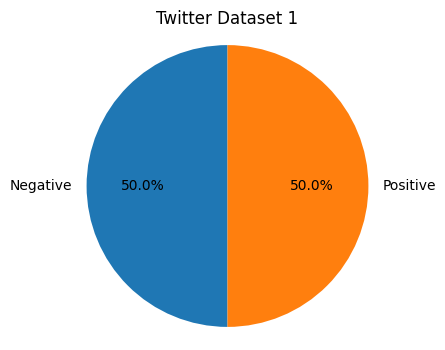

In [ ]:
# Plotting the pie chart
labels_count = train_tw1['label'].value_counts()
sentiment_mapping = {0: 'Negative', 4: 'Positive'}
labels_count.index = labels_count.index.map(sentiment_mapping)
plt.figure(figsize=(4, 4), dpi=100)
plt.pie(labels_count, labels=labels_count.index, autopct='%1.1f%%', startangle=90)
plt.title("Twitter Dataset 1")
plt.axis('equal')
plt.show()

In [ ]:
# Drop some cols
train_tw1 = train_tw1.drop(columns=["ids", "date", "flag", "user"])
# Drop NaN values
train_tw1 = train_tw1.dropna()

train_tw1.head(5)

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Dataset cleaning
def cleaning(text, txt_cleaning_re, stop_words):
    # Remove link,user and special characters
    text = re.sub(txt_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

In [ ]:
# Clean tw1
txt_cleaning_re = "@\S+|https?:\S+|https?:\S+|www\S+|[^A-Za-z0-9':;,.!?()><~]" # Cleaning rules
stop_words = stopwords.words("english") # Exclude stopwords

# Clean tweets text
train_tw1["text"] = train_tw1["text"].apply(lambda x: cleaning(x, txt_cleaning_re, stop_words))
train_tw1.head(5)

In [ ]:
# Function to preprocess Twitter dataset 1
def preprocess_tw1(data):
  # take a batch of texts
  text = data["text"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # create numpy array of shape (batch_size, num_labels)
  labels = np.zeros((len(text), 1), dtype=int)
  # fill numpy array
  for idx, label in enumerate(data["label"]):
    if label == 0: # following the way FinBERT label sentiments 0:positive, 1:negative, 2:neutral
      labels[idx] = 1
    elif label == 2:
      labels[idx] = 2
    else:
      labels[idx] = 0

  encoding["label"] = labels.tolist()
  return encoding

# Train_test split (Due to imbalanced data; we will not use the most of the data)
train_tw1, val_tw1 = train_test_split(train_tw1, stratify=train_tw1["label"], test_size=0.7, random_state=42) # The train set would only contain 30% of the total data points
_, val_tw1 = train_test_split(val_tw1, stratify=val_tw1["label"], test_size=0.2, random_state=42) # The val set would only contain around 14% of the total data points

In [ ]:
# Add one neutral label to train and val dataset each to get around with the ruc_auc_score requirement
train_tw1.iloc[0, 0] = 2
val_tw1.iloc[1, 0] = 2

In [ ]:
# Transformed into Hugging face dataset
train_tw1 = Dataset.from_pandas(train_tw1)
val_tw1 = Dataset.from_pandas(val_tw1)

# Train
train_tw1 = train_tw1.map(preprocess_tw1, batched=True)
train_tw1.set_format(type='torch', columns=["input_ids", "token_type_ids", "attention_mask", "label"])

# Val
val_tw1 = val_tw1.map(preprocess_tw1, batched=True)
val_tw1.set_format(type='torch', columns=["input_ids", "token_type_ids", "attention_mask", "label"])

Map:   0%|          | 0/480000 [00:00<?, ? examples/s]

Map:   0%|          | 0/224000 [00:00<?, ? examples/s]

### Twitter Dataset 2

In [ ]:
# Import from Huggingface Hub (Balanced dataset with three labels); 0:negative; 1:neutral; 2:positive
train_tw2 = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset", split="train")
val_tw2 = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset", split="validation")

# Inspection
train_tw2[0]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{'id': 9536,
 'text': 'Cooking microwave pizzas, yummy',
 'label': 2,
 'sentiment': 'positive'}

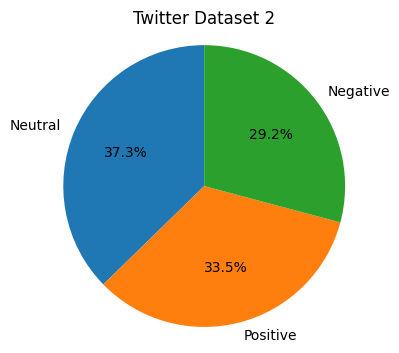

In [ ]:
# Plotting the pie chart
temp = pd.DataFrame(train_tw2)
labels_count = temp['label'].value_counts()
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2:'Positive'}
labels_count.index = labels_count.index.map(sentiment_mapping)
plt.figure(figsize=(4, 4), dpi=100)
plt.pie(labels_count, labels=labels_count.index, autopct='%1.1f%%', startangle=90)
plt.title("Twitter Dataset 2")
plt.axis('equal')
plt.show()

In [ ]:
# Function to preprocess Twitter dataset 2
def preprocess_tw2(data):
  # take a batch of texts
  text = data["text"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # create numpy array of shape (batch_size, num_labels)
  labels = np.zeros((len(text), 1), dtype=int)
  # fill numpy array
  for idx, label in enumerate(data["label"]):
    if label == 0: # following the way FinBERT label sentiments 0:positive, 1:negative, 2:neutral
      labels[idx] = 1
    elif label == 2:
      labels[idx] = 0
    else:
      labels[idx] = 2

  encoding["label"] = labels.tolist()
  return encoding

# Train
train_tw2 = train_tw2.map(preprocess_tw2, batched=True, remove_columns=["id", "sentiment"])
train_tw2.set_format(type='torch', columns=["input_ids", "token_type_ids", "attention_mask", "label"])

# Val
val_tw2 = val_tw2.map(preprocess_tw2, batched=True, remove_columns=["id", "sentiment"])
val_tw2.set_format(type='torch', columns=["input_ids", "token_type_ids", "attention_mask", "label"])

Map:   0%|          | 0/31232 [00:00<?, ? examples/s]

Map:   0%|          | 0/5205 [00:00<?, ? examples/s]

### Financial Phrasebank Dataset (formal and standard finance language bank)

In [ ]:
# Import dataset; 0:negative; 1:neutral; 2:positive
fin_phrsbank_allagree = load_dataset('financial_phrasebank', 'sentences_allagree', split="train")

# Inspection
fin_phrsbank_allagree[0]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
 'label': 1}

In [ ]:
# Function to
def preprocess_finphrs(data):
  # take a batch of texts
  text = data["sentence"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # create numpy array of shape (batch_size, num_labels)
  labels = np.zeros((len(text), 1), dtype=int)
  # fill numpy array
  for idx, label in enumerate(data["label"]):
    if label == 0: # following the way FinBERT label sentiments 0:positive, 1:negative, 2:neutral
      labels[idx] = 1
    elif label == 2:
      labels[idx] = 0
    else:
      labels[idx] = 2

  encoding["label"] = labels.tolist()
  return encoding

# Preprocess
fin_phrsbank_allagree = fin_phrsbank_allagree.map(preprocess_finphrs, batched=True)
fin_phrsbank_allagree.set_format(type='torch', columns=["input_ids", "token_type_ids", "attention_mask", "label"])

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

## Baseline Evaluation (before fine-tuning)

### Twitter Dataset 1

In [ ]:
# Trainer for tw1
args_tw1 = TrainingArguments(
    output_dir = "/content/drive/MyDrive/ESE 546/Project/FinBERT/tw1_finetune",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1'
)

trainer_tw1 = Trainer(
    model,
    args_tw1,
    train_dataset=train_tw1,
    eval_dataset=val_tw1,
    compute_metrics=compute_metrics
)

# Evaluation
trainer_tw1.evaluate()

{'eval_loss': 2.4094879627227783,
 'eval_f1': 0.09620535714285715,
 'eval_roc_auc': 0.36562753684032206,
 'eval_accuracy': 0.09620535714285715,
 'eval_runtime': 498.3617,
 'eval_samples_per_second': 449.473,
 'eval_steps_per_second': 14.046}

### Twitter Dataset 2

In [ ]:
# Trainer for tw2
args_tw2 = TrainingArguments(
    output_dir = "/content/drive/MyDrive/ESE 546/Project/FinBERT/tw2_finetune",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1'
)

trainer_tw2 = Trainer(
    model,
    args_tw2,
    train_dataset=train_tw2,
    eval_dataset=val_tw2,
    compute_metrics=compute_metrics
)

# Evaluation
trainer_tw2.evaluate()

{'eval_loss': 1.3021389245986938,
 'eval_f1': 0.4605187319884726,
 'eval_roc_auc': 0.6949382521240106,
 'eval_accuracy': 0.4605187319884726,
 'eval_runtime': 11.524,
 'eval_samples_per_second': 451.667,
 'eval_steps_per_second': 14.144}

### Financial Phrasebank

In [ ]:
# Only for eval purpose
args_fin = TrainingArguments(
    output_dir = "/content/drive/MyDrive/ESE 546/Project/FinBERT/finphrs",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=8,
    num_train_epochs=0.1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

trainer_fin = Trainer(
    model,
    args_fin,
    train_dataset=fin_phrsbank_allagree,
    eval_dataset=fin_phrsbank_allagree,
    compute_metrics=compute_metrics
)

# Evaluation
trainer_fin.evaluate()

{'eval_loss': 0.13164396584033966,
 'eval_f1': 0.9717314487632509,
 'eval_roc_auc': 0.9956157661320532,
 'eval_accuracy': 0.9717314487632509,
 'eval_runtime': 6.1735,
 'eval_samples_per_second': 366.727,
 'eval_steps_per_second': 45.841}

## Fine-tune

### Fine-tune on tw2

In [ ]:
trainer_tw2.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.572619,0.755043,0.911565,0.755043
2,0.631600,0.568340,0.761768,0.917878,0.761768
3,0.489000,0.604807,0.761383,0.915551,0.761383
4,0.390700,0.680348,0.758694,0.912613,0.758694


### Fine-tune on tw1

In [ ]:
# Tuned on tw1 to reinforce the the predictive power on positive and negative data
# The fine-tuning was interruptted due to comsumed storeage by checkpoint and thereby only
# 3 eopchs of training had been performed but since the F1 score had declined after epoch 2
# the best fine-tuned model was stored already after the checkpoint 2. We used the model with
# the best F1 score
trainer_tw1.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.404600,0.395371,0.819973,0.951193,0.819973
2,0.347600,0.402946,0.820652,0.951533,0.820652
3,0.288600,0.432185,0.819036,0.950611,0.819036


FailedPreconditionError: ignored

## Evaluation (after fine-tuning)

In [ ]:
# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/ESE 546/Project/FinBERT/tw1_finetune/checkpoint-15000")
tokenizer =  AutoTokenizer.from_pretrained("ProsusAI/finbert")

### Twitter Dataset 1

In [ ]:
# Evaluation for tw1
args_tw1 = TrainingArguments(
    output_dir = "/content/drive/MyDrive/ESE 546/Project/FinBERT/tw1_finetune/sudo_checkpoint",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1'
)

trainer_tw1 = Trainer(
    model,
    args_tw1,
    train_dataset=train_tw1,
    eval_dataset=val_tw1,
    compute_metrics=compute_metrics
)

# Evaluation
trainer_tw1.evaluate()

{'eval_loss': 0.40294593572616577,
 'eval_f1': 0.8206517857142858,
 'eval_roc_auc': 0.9515332210419324,
 'eval_accuracy': 0.8206517857142858,
 'eval_runtime': 440.4007,
 'eval_samples_per_second': 508.628,
 'eval_steps_per_second': 3.974}

### Twitter Dataset 2

In [ ]:
# Trainer for tw2
args_tw2 = TrainingArguments(
    output_dir = "/content/drive/MyDrive/ESE 546/Project/FinBERT/tw2_finetune/sudo_checkpoint",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1'
)

trainer_tw2 = Trainer(
    model,
    args_tw2,
    train_dataset=train_tw2,
    eval_dataset=val_tw2,
    compute_metrics=compute_metrics
)

# Evaluation
trainer_tw2.evaluate()

{'eval_loss': 4.346683979034424,
 'eval_f1': 0.5342939481268012,
 'eval_roc_auc': 0.6332599722612098,
 'eval_accuracy': 0.5342939481268012,
 'eval_runtime': 11.3519,
 'eval_samples_per_second': 458.512,
 'eval_steps_per_second': 14.359}

### Financial Phrasebank

In [ ]:
# Only for eval purpose
args_fin = TrainingArguments(
    output_dir = "/content/drive/MyDrive/ESE 546/Project/FinBERT/finphrs",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=0.1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

trainer_fin = Trainer(
    model,
    args_fin,
    train_dataset=fin_phrsbank_allagree,
    eval_dataset=fin_phrsbank_allagree,
    compute_metrics=compute_metrics
)

# Evaluation
trainer_fin.evaluate()

{'eval_loss': 4.633175849914551,
 'eval_f1': 0.37985865724381623,
 'eval_roc_auc': 0.4893912943725106,
 'eval_accuracy': 0.37985865724381623,
 'eval_runtime': 4.983,
 'eval_samples_per_second': 454.348,
 'eval_steps_per_second': 14.249}

In [ ]:
# Save model
trainer_tw1.save_model("/content/drive/MyDrive/ESE 546/Project/Fine-tuned FinBERT")

## Inference on Reddit text

In [ ]:
# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/ESE 546/Project/Fine-tuned FinBERT")
tokenizer =  AutoTokenizer.from_pretrained("ProsusAI/finbert")

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Preprocessing and Posts Selection

In [ ]:
col_names = ["Score", "Date", "Title", "User", "URL", "Post"]
wsb_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/wallstreetbets_submissions_2019-2021.csv", names=col_names)
amc_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/amcstock_submissions_2019-2021.csv", names=col_names)
gme_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/GME_submissions_2019-2021.csv", names=col_names)
btc_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Bitcoin_submissions_2019-2021.csv", names=col_names)
eth_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/ethereum_submissions_2019-2021.csv", names=col_names)

In [ ]:
wsb_df.head(10)

,Score,Date,Title,User,URL,Post
0,14,2019-01-01,Financial C++ Coding,u/fismarce,https://www.reddit.com/r/wallstreetbets/commen...,Not sure if this belongs here but I'm interest...
1,1,2019-01-01,My face on last minute of trading...,u/[deleted],https://www.reddit.com/r/wallstreetbets/commen...,https://i.redd.it/6cv3yfsdhp721.jpg
2,18,2019-01-01,How did you autists get into the finance jobs ...,u/redditingatschool14,https://www.reddit.com/r/wallstreetbets/commen...,I watched Wolf of Wall Street 2 weeks ago and ...
3,18,2019-01-01,2018 is almost finished. What was your funnest...,u/Smit_W,https://www.reddit.com/r/wallstreetbets/commen...,My greatest and funnest trade was making $6k i...
4,0,2019-01-01,$ULTA 2 the moon!! Think about all the lipstic...,u/gwizzop,https://www.reddit.com/r/wallstreetbets/commen...,NaN
5,1,2019-01-01,2019 IRA Contribution,u/[deleted],https://www.reddit.com/r/wallstreetbets/commen...,[deleted]
6,112,2019-01-01,To all SPX Call Holders at 2495/2500... you’re...,u/cydworth,https://www.reddit.com/r/wallstreetbets/commen...,https://v.redd.it/p9yozoijop721
7,1,2019-01-01,Can we submit our own user-submitted WSB banne...,u/[deleted],https://www.reddit.com/r/wallstreetbets/commen...,[deleted]
8,25,2019-01-01,Zuck lost 22 Big,u/macrodog,https://www.reddit.com/r/wallstreetbets/commen...,https://i.redd.it/dp4wu9sxrp721.jpg
9,110,2019-01-01,The Last USO DD Post of 2018!,u/GeoDudeBroMan,https://www.reddit.com/r/wallstreetbets/commen...,"Happy holidays you degenerate autistic fucks, ..."


In [ ]:
amc_df.head(10)

,Score,Date,Title,User,URL,Post
0,2931,2021-01-27,r/amcstock Lounge,u/[deleted],https://www.reddit.com/r/amcstock/comments/l6b...,[deleted]
1,17,2021-01-27,Hello!,u/SaganSaga,https://www.reddit.com/r/amcstock/comments/l6b...,"First time making a community on Reddit, not 1..."
2,12,2021-01-27,AMC,u/Streetbobhero,https://www.reddit.com/r/amcstock/comments/l6g...,"Come on, come on!"
3,3,2021-01-27,Great idea,u/hospwr,https://www.reddit.com/r/amcstock/comments/l6g...,NaN
4,9,2021-01-27,Jan 27 after hours discussion thread 👍🏽🚀🚀,u/SaganSaga,https://www.reddit.com/r/amcstock/comments/l6g...,NaN
5,7,2021-01-27,"We need to get the word out, the moderator shu...",u/hospwr,https://www.reddit.com/r/amcstock/comments/l6g...,NaN
6,13,2021-01-27,Is AMC gonna go back up,u/BubbsGSH34,https://www.reddit.com/r/amcstock/comments/l6g...,What is everyone’s thoughts on amc’s forecast ...
7,3,2021-01-27,$18.20 fml,u/[deleted],https://www.reddit.com/r/amcstock/comments/l6h...,I bought in too late. They talked about this s...
8,2,2021-01-27,DISCORD,u/Dynamicthetoon,https://www.reddit.com/r/amcstock/comments/l6h...,https://discord.gg/dRE9ejQS
9,3,2021-01-27,What’s happening with AMC??,u/Everybodyylies,https://www.reddit.com/r/amcstock/comments/l6i...,NaN


In [ ]:
gme_df.head(10)

,Score,Date,Title,User,URL,Post
0,8,2020-10-30,GME,u/BigDollaDreamer,https://www.reddit.com/r/GME/comments/jktv8x/gme/,GME TO THE MOOOOOOON
1,1,2020-11-01,Soon enough gang 🚀,u/[deleted],https://www.reddit.com/r/GME/comments/jly48t/s...,https://i.redd.it/4jjfkjb9skw51.jpg
2,11,2020-11-01,Soon enough gang 🚀,u/IsaacPG,https://www.reddit.com/r/GME/comments/jly4ex/s...,https://i.redd.it/helqwkjcskw51.jpg
3,8,2020-11-02,Thoughts on future?,u/BigDollaDreamer,https://www.reddit.com/r/GME/comments/jmeywl/t...,I know we may have a small following on this s...
4,6,2020-11-17,New development from RC,u/leoschen,https://www.reddit.com/r/GME/comments/jvws72/n...,/r/wallstreetbets/comments/jviqn2/gme_wsj_excl...
5,2,2020-11-27,Rise and Grind,u/BigDollaDreamer,https://www.reddit.com/r/GME/comments/k22bhg/r...,🌝
6,10,2020-12-01,Update: Whassup bro?,u/matt_xndever,https://www.reddit.com/r/GME/comments/k4nllk/u...,I took a small position in GME because Cyber M...
7,5,2020-12-01,SA writer speaks with Ryan Cohen,u/Control_the_Guh,https://www.reddit.com/r/GME/comments/k4opez/s...,"Quote: ""I've recently had the pleasure of havi..."
8,1,2020-12-04,For Those Who Don't Understand the Inevitable ...,u/[deleted],https://www.reddit.com/r/GME/comments/k6dud8/f...,/r/stocks/comments/k688qv/for_those_who_dont_u...
9,0,2020-12-05,Trash,u/[deleted],https://www.reddit.com/r/GME/comments/k70wh0/t...,[deleted]


In [ ]:
btc_df.head(10)

,Score,Date,Title,User,URL,Post
0,0,2019-01-01,Are these accurate criticisms of Lightning Net...,u/bearCatBird,https://www.reddit.com/r/Bitcoin/comments/abcw...,I'm excited about LN. I'm in progress setting ...
1,189,2019-01-01,May The Bulls Be With You In This 2019!,u/asazot,https://www.reddit.com/r/Bitcoin/comments/abcx...,https://i.redd.it/io3ezmi2ep721.png
2,6,2019-01-01,How to open a Bitcoin wallet without a bank ac...,u/SMVR2,https://www.reddit.com/r/Bitcoin/comments/abcx...,"Hi, please don’t make fun of me, I’m new to Cr..."
3,1,2019-01-01,"Bitcoin Could Revolutionize Governance, Says C...",u/cryptodailynews,https://www.reddit.com/r/Bitcoin/comments/abcy...,http://cryptodailynewsu.blogspot.com/2018/12/b...
4,30,2019-01-01,"Bitcoin Could Revolutionize Governance. ""“I be...",u/EducationalLadder,https://www.reddit.com/r/Bitcoin/comments/abcz...,https://www.coinfi.com/news/421449/bitcoin-cou...
5,1,2019-01-01,Merry New Year! 🥳🎉,u/[deleted],https://www.reddit.com/r/Bitcoin/comments/abda...,[removed]
6,0,2019-01-01,"Where I live, in the next four hours, Bitcoin ...",u/[deleted],https://www.reddit.com/r/Bitcoin/comments/abdc...,[deleted]
7,1,2019-01-01,25 bucks of bitcoin w/freesignup on Voyager,u/RogueGainz,https://www.reddit.com/r/Bitcoin/comments/abdd...,https://www.investvoyager.com/?campaignId=nAHw...
8,6,2019-01-01,Happy New Year! :) (pic by @CryptoScamHub),u/chek2fire,https://www.reddit.com/r/Bitcoin/comments/abdk...,https://i.redd.it/u6bkk7y0rp721.jpg
9,15,2019-01-01,Who's ready to USE Bitcoin in 2019?,u/diydude2,https://www.reddit.com/r/Bitcoin/comments/abdm...,Forget price. Let's talk about VALUE.\n\nIf I ...


In [ ]:
eth_df.head(10)

,Score,Date,Title,User,URL,Post
0,0,2019-01-01,"ETHERUM HACKED 😭 how and why , never opened on...",u/[deleted],https://www.reddit.com/r/ethereum/comments/abd...,https://etherscan.io/address/0x8b89cb372c1c441...
1,6,2019-01-01,What is the value of letting average users be ...,u/bijansha,https://www.reddit.com/r/ethereum/comments/abd...,I'm trying to think from a use case perspectiv...
2,0,2019-01-01,CryptoClickies Click Your Way to Tokens,u/ScarlettAlfie,https://www.reddit.com/r/ethereum/comments/abd...,[removed]
3,6,2019-01-01,"Hacked , who can help me please",u/mikelthepina,https://www.reddit.com/r/ethereum/comments/abd...,[removed]
4,12,2019-01-01,Happy New Year from the GoChain team! 🥳 Check ...,u/Cy4cent,https://www.reddit.com/r/ethereum/comments/abd...,https://medium.com/gochain/gochain-development...
5,72,2019-01-01,Unsolved Problems in Blockchain Sharding,u/fagnerbrack,https://www.reddit.com/r/ethereum/comments/abe...,https://medium.com/nearprotocol/unsolved-probl...
6,43,2019-01-01,"Where do ""slashed"" tokens go to? And what if a...",u/c-i-s-c-o,https://www.reddit.com/r/ethereum/comments/abf...,"I know this is unlikely, but just wondering if..."
7,1,2019-01-01,Wait - I thought staking was via smart contrac...,u/nsudhir007,https://www.reddit.com/r/ethereum/comments/abg...,So another post today asked about losing inter...
8,8,2019-01-01,"Bernhard Mueller pokes ""Maximalists""",u/unitedstatian,https://www.reddit.com/r/ethereum/comments/abg...,https://twitter.com/muellerberndt/status/10789...
9,1,2019-01-01,How detection of fake drugs works using blockc...,u/prayaglehana,https://www.reddit.com/r/ethereum/comments/abg...,[removed]


In [ ]:
# Function to preprocess dataframe
def df_process(df):
  # Drop NaN
  df = df.dropna(subset=["Title", "Date"])
  # Fill NaN for Post col
  df["Post"] = df["Post"].fillna(" ")
  # Merge title and post
  df["Text"] = df["Title"] + " " + df["Post"]
  # Drop Title and Post; drop Users and URL
  df = df.drop(columns=["User", "URL", "Title", "Post"])
  # Set Date as index
  df = df.set_index("Date")
  return df

In [ ]:
# Processing
wsb_df = df_process(wsb_df)
amc_df = df_process(amc_df)
gme_df = df_process(gme_df)
btc_df = df_process(btc_df)
eth_df = df_process(eth_df)

In [ ]:
# Look at one example
amc_df.head(5)

,Score,Text
Date,,
2021-01-27,2931,r/amcstock Lounge [deleted]
2021-01-27,17,Hello! First time making a community on Reddit...
2021-01-27,12,"AMC Come on, come on!"
2021-01-27,3,Great idea
2021-01-27,9,Jan 27 after hours discussion thread 👍🏽🚀🚀


In [ ]:
# Look at another example
btc_df.head(5)

,Score,Text
Date,,
2019-01-01,0,Are these accurate criticisms of Lightning Net...
2019-01-01,189,May The Bulls Be With You In This 2019! https:...
2019-01-01,6,How to open a Bitcoin wallet without a bank ac...
2019-01-01,1,"Bitcoin Could Revolutionize Governance, Says C..."
2019-01-01,30,"Bitcoin Could Revolutionize Governance. ""“I be..."


In [ ]:
# Function to select posts that meet criteria
def select_posts(df, num_posts, name_of_stock, rules):
  df_1 = pd.DataFrame()
  rules_1 = [name + "|" for name in name_of_stock]
  rules_1 = ''.join(rules_1)[:-1]

  for date in np.sort(df.index.unique()):
    temp = df.loc[date]

    if not isinstance(temp, pd.Series):
      temp = temp[temp["Text"].str.contains(rules, flags=re.IGNORECASE, regex=True)] # Contain certain words to be considered
      temp = temp[temp["Text"].str.contains(rules_1, flags=re.IGNORECASE, regex=True)]

      if temp.shape[0] > num_posts: # Only to get the first 'num_posts' number of posts
        temp = temp.sort_values(by="Score", ascending=False).iloc[:num_posts]

    else:
      temp = temp.to_frame().T

    df_1 = pd.concat([df_1, temp]) # Vertical concat

  return df_1

In [ ]:
# Mutual words to consider in the post
bag_of_words = ["stock", "buy", "sell", "bought", "sold", "hold", "up", "down",
                "diamond","paper", "mars", "earn", "loss",
                "broke", "rise", "rocket", "surge", "dump", "drop", "dip"]
rules = [word + "|" for word in bag_of_words]
rules = ''.join(rules)[:-1]

# Special words for different targets
name_of_GME = ["gme", "game stop"]
name_of_AMC = ["amc"]
name_of_BTC = ["btc", "bitcoin", "bit coin"]
name_of_ETH = ["eth", "ethereum"]

# Number of posts for every day from each subreddit
num_posts = 30

# GME
gme_df = select_posts(gme_df, num_posts, name_of_GME, rules) # GME posts from GME subreddit
gme_wsb_df = select_posts(wsb_df, num_posts, name_of_GME, rules) # GME posts from WSB subreddit

# AMC
amc_df = select_posts(amc_df, num_posts, name_of_AMC, rules)
amc_wsb_df = select_posts(wsb_df, num_posts, name_of_AMC, rules)

# BTC
btc_df = select_posts(btc_df, num_posts, name_of_BTC, rules)
btc_wsb_df = select_posts(wsb_df, num_posts, name_of_BTC, rules)

# ETH
eth_df = select_posts(eth_df, num_posts, name_of_ETH, rules)
eth_wsb_df = select_posts(wsb_df, num_posts, name_of_ETH, rules)

In [ ]:
# Look at one example
amc_df.head(5)

,Score,Text
Date,,
2021-01-27,2931,r/amcstock Lounge [deleted]
2021-01-27,13,Is AMC gonna go back up What is everyone’s tho...
2021-01-28,140,"BUY AMC!! DO NOT SELL, HOLD AND ITLL GO TO THE..."
2021-01-28,122,HOLD AMC!!! [removed]
2021-01-28,105,still hold guys?? Amc?? BB?? [removed]


In [ ]:
# Dataset cleaning
def cleaning(text, txt_cleaning_re):
    # Remove link,user and special characters
    text = re.sub(txt_cleaning_re, ' ', str(text).lower()).strip()
    return text

# Clean text
txt_cleaning_re = "@\\S+|https?:\\S+|https?:\\S+|www\\S+|[^A-Za-z0-9':;,.!?()><~]|\W*(deleted)\W*|\W*(delete)\W*|\W*(removed)\W*|\W*(remove)\W*" # Cleaning rules

# Clean Reddit text
amc_df["Text"] = amc_df["Text"].apply(lambda x: cleaning(x, txt_cleaning_re))
amc_wsb_df["Text"] = amc_wsb_df["Text"].apply(lambda x: cleaning(x, txt_cleaning_re))

gme_df["Text"] = gme_df["Text"].apply(lambda x: cleaning(x, txt_cleaning_re))
gme_wsb_df["Text"] = gme_wsb_df["Text"].apply(lambda x: cleaning(x, txt_cleaning_re))

btc_df["Text"] = btc_df["Text"].apply(lambda x: cleaning(x, txt_cleaning_re))
btc_wsb_df["Text"] = btc_wsb_df["Text"].apply(lambda x: cleaning(x, txt_cleaning_re))

eth_df["Text"] = eth_df["Text"].apply(lambda x: cleaning(x, txt_cleaning_re))
eth_wsb_df["Text"] = eth_wsb_df["Text"].apply(lambda x: cleaning(x, txt_cleaning_re))

In [ ]:
# Store processed files
amc_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/amcstock_submissions_2019-2021.csv")
amc_wsb_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/amc_wsb_submissions_2019-2021.csv")

gme_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/GME_submissions_2019-2021.csv")
gme_wsb_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/GME_wsb_submissions_2019-2021.csv")

btc_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/Bitcoin_submissions_2019-2021.csv")
btc_wsb_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/Bitcoin_wsb_submissions_2019-2021.csv")

eth_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/ethereum_submissions_2019-2021.csv")
eth_wsb_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/ethereum_wsb_submissions_2019-2021.csv")

### Inference

In [ ]:
# Load files
amc_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/amcstock_submissions_2019-2021.csv")
amc_wsb_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/amc_wsb_submissions_2019-2021.csv")

gme_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/GME_submissions_2019-2021.csv")
gme_wsb_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/GME_wsb_submissions_2019-2021.csv")

btc_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/Bitcoin_submissions_2019-2021.csv")
btc_wsb_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/Bitcoin_wsb_submissions_2019-2021.csv")

eth_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/ethereum_submissions_2019-2021.csv")
eth_wsb_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/ethereum_wsb_submissions_2019-2021.csv")

In [ ]:
# Set cols and index
cols_names = ["Date", "Score", "Text"]

amc_df.columns = cols_names
amc_wsb_df.columns = cols_names
amc_df = amc_df.set_index("Date")
amc_wsb_df = amc_wsb_df.set_index("Date")

gme_df.columns = cols_names
gme_wsb_df.columns = cols_names
gme_df = gme_df.set_index("Date")
gme_wsb_df = gme_wsb_df.set_index("Date")

btc_df.columns = cols_names
btc_wsb_df.columns = cols_names
btc_df = btc_df.set_index("Date")
btc_wsb_df = btc_wsb_df.set_index("Date")

eth_df.columns = cols_names
eth_wsb_df.columns = cols_names
eth_df = eth_df.set_index("Date")
eth_wsb_df = eth_wsb_df.set_index("Date")

In [ ]:
# Some examples
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)
nlp(["AMC to the moon",
     "new regulation put stricter policy against btc",
     "YOLO",
     "robinhood shut their systems anyone experiencing the same? "], **tokenizer_kwargs)

In [ ]:
# Function to make inference
def inference(df):
  df["Text"] = df["Text"].astype(str)
  tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
  nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device, **tokenizer_kwargs)
  results = nlp(df["Text"].to_list())
  sentiment_score = []

  # Add sentiment score to dataframe
  # If negative flip the sign; if neutral set it to 0
  for result in results:
    if result["label"] == "negative":
      result["score"] = -result["score"]
    elif result["label"] == "neutral":
      result["score"] = 0
    sentiment_score.append(result["score"])

  df["Sentiment Score"] = sentiment_score
  return df

In [ ]:
# Get sentiment score for each df
amc_df = inference(amc_df)
amc_wsb_df = inference(amc_wsb_df)

gme_df = inference(gme_df)
gme_wsb_df = inference(gme_wsb_df)

btc_df = inference(btc_df)
btc_wsb_df = inference(btc_wsb_df)

eth_df = inference(eth_df)
eth_wsb_df = inference(eth_wsb_df)

In [ ]:
# Store files with sentiment scores
amc_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/amcstock_submissions_2019-2021.csv")
amc_wsb_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/amc_wsb_submissions_2019-2021.csv")

gme_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/GME_submissions_2019-2021.csv")
gme_wsb_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/GME_wsb_submissions_2019-2021.csv")

btc_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/Bitcoin_submissions_2019-2021.csv")
btc_wsb_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/Bitcoin_wsb_submissions_2019-2021.csv")

eth_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/ethereum_submissions_2019-2021.csv")
eth_wsb_df.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/ethereum_wsb_submissions_2019-2021.csv")

### Compute Final Sentiment Scores

In [ ]:
# Load files
amc_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/amcstock_submissions_2019-2021.csv")
amc_wsb_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/amc_wsb_submissions_2019-2021.csv")

gme_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/GME_submissions_2019-2021.csv")
gme_wsb_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/GME_wsb_submissions_2019-2021.csv")

btc_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/Bitcoin_submissions_2019-2021.csv")
btc_wsb_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/Bitcoin_wsb_submissions_2019-2021.csv")

eth_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/ethereum_submissions_2019-2021.csv")
eth_wsb_df = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/ethereum_wsb_submissions_2019-2021.csv")

# Set cols and index
cols_names = ["Date", "Score", "Text", "Sentiment Score"]

amc_df.columns = cols_names
amc_wsb_df.columns = cols_names
amc_df = amc_df.set_index("Date")
amc_wsb_df = amc_wsb_df.set_index("Date")

gme_df.columns = cols_names
gme_wsb_df.columns = cols_names
gme_df = gme_df.set_index("Date")
gme_wsb_df = gme_wsb_df.set_index("Date")

btc_df.columns = cols_names
btc_wsb_df.columns = cols_names
btc_df = btc_df.set_index("Date")
btc_wsb_df = btc_wsb_df.set_index("Date")

eth_df.columns = cols_names
eth_wsb_df.columns = cols_names
eth_df = eth_df.set_index("Date")
eth_wsb_df = eth_wsb_df.set_index("Date")

In [ ]:
# Final sentiment score for each stock
def sentiment_score(df1, df2):
  # df1 and df2 are two time-series df storing sentiment scores for the same stock from two subreddits
  # The final sentiment score each day is the simple average for the weighted average reddit score (popularity) for the above two
  # Wighted average reddit score(popularity) is calculated based on the original sentiment score each day (see details in report)

  # Compute product of sentiment score and its Reddit score (popularity) as numerator
  # Reddit score sum for each day as denominator
  df1 = (df1["Sentiment Score"] * df1["Score"] / df1.groupby(by="Date")["Score"].sum()).groupby("Date").sum().to_frame()
  df1.columns = ["Sentiment Score"]

  df2 = (df2["Sentiment Score"] * df2["Score"] / df2.groupby(by="Date")["Score"].sum()).groupby("Date").sum().to_frame()
  df2.columns = ["Sentiment Score"]

  df = pd.merge(left=df1, right=df2, how="outer", left_index=True,right_index=True).mean(axis=1).to_frame()
  df.columns = ["Sentiment Score"]
  return df

# Computation
amc_sentiment = sentiment_score(amc_df, amc_wsb_df)
gme_sentiment = sentiment_score(gme_df, gme_wsb_df)
btc_sentiment = sentiment_score(btc_df, btc_wsb_df)
eth_sentiment = sentiment_score(eth_df, eth_wsb_df)

# Store sentiments
amc_sentiment.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/Sentiments/amc_sentiment.csv")
gme_sentiment.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/Sentiments/gme_sentiment.csv")
btc_sentiment.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/Sentiments/btc_sentiment.csv")
eth_sentiment.to_csv("/content/drive/MyDrive/ESE 546/Project/Reddit Text/Sentiments/eth_sentiment.csv")

## Finalize Input Data

In [ ]:
# Load trading data with technical indictors
amc_trading = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Trading Data/AMC_withTA.csv", index_col="Date")
gme_trading = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Trading Data/GME_withTA.csv", index_col="Date")
btc_trading = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Trading Data/BTC-USD_withTA.csv", index_col="Date")
eth_trading = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Trading Data/ETH-USD_withTA.csv", index_col="Date")

# Merge two dfs
# First shift the sentiment df by 1 as we can only use the past data to make prediction
amc_sentiment = amc_sentiment.shift()
gme_sentiment = gme_sentiment.shift()
btc_sentiment = btc_sentiment.shift()
eth_sentiment = eth_sentiment.shift()

# Merge
amc_trading = pd.merge(left=amc_trading, right=amc_sentiment, how="left", left_index=True, right_index=True)
gme_trading = pd.merge(left=gme_trading, right=gme_sentiment, how="left", left_index=True, right_index=True)
btc_trading = pd.merge(left=btc_trading, right=btc_sentiment, how="left", left_index=True, right_index=True)
eth_trading = pd.merge(left=eth_trading, right=eth_sentiment, how="left", left_index=True, right_index=True)

In [ ]:
# See one example
amc_trading

,Open,High,Low,Adj Close,Turnover,SMA_5,EMA_5,WMA_5,SMA_10,EMA_10,...,ADX_10,MACD,OBV,ADOSC,ATR,Close_STD,Daily return,Target,Corr,Sentiment Score
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-20,-0.196950,-0.687670,-0.766540,-1.494225,2.089181,-1.647438,-1.668401,-1.583905,-2.632152,-1.883668,...,-1.627608,-0.707107,0.595045,-0.901912,-0.469491,-0.387722,-0.042785,1,0.904935,NaN
2019-02-21,-0.914074,-0.626922,-0.617162,-0.430848,1.497431,-1.288534,-1.353411,-1.299491,-2.428700,-1.658260,...,-1.631489,-0.326274,1.527101,-1.053234,0.067468,-0.571472,0.035606,1,0.854985,NaN
2019-02-22,-0.295368,-0.591294,0.013142,-0.356852,-0.992045,-1.110191,-1.111256,-1.099945,-2.177235,-1.465157,...,-1.625621,0.201421,1.813530,-1.086529,-0.677377,-0.524052,0.002195,1,0.804477,NaN
2019-02-25,0.062201,0.445722,0.386932,0.034416,-0.302499,-0.925573,-0.742380,-0.770285,-1.758179,-1.171092,...,-1.596196,1.148970,2.163373,-1.297484,-0.240969,-0.273673,0.012409,-1,0.866680,NaN
2019-02-26,0.400407,0.051863,0.142028,-0.494927,0.523204,-1.000733,-0.784314,-0.758640,-1.667048,-1.146472,...,-1.644222,0.962393,1.413071,-2.006254,-0.429311,-0.368697,-0.016582,-1,0.885864,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,1.119724,1.037823,1.083922,1.026918,-0.001808,1.018377,1.031491,1.062761,0.930952,1.040541,...,-0.266648,-1.370486,2.218344,0.758471,1.070127,0.948501,-0.053465,-1,0.868623,0.173461
2021-12-27,1.039531,0.964929,0.988954,1.013933,-0.003427,1.076235,1.028433,1.062945,0.922907,1.038934,...,-0.384952,-1.285073,2.187261,0.669574,1.000090,-0.083059,-0.005579,1,0.832429,-0.016902
2021-12-28,1.001011,0.960970,1.002205,1.025599,-0.056123,1.068573,1.030311,1.047772,0.930977,1.039773,...,-0.491345,-1.197165,2.197582,0.676185,0.923630,-0.054838,0.006311,-1,0.828724,-0.255473


In [ ]:
# Strategy to fill NaN Sentiment Score: Time based interpolation (since we can only use the past information)
# We cannot simply drop NaN value as these are trading days and thereby valuable; we want to maximize data we have
amc_trading.index = pd.to_datetime(amc_trading.index)
gme_trading.index = pd.to_datetime(gme_trading.index)
btc_trading.index = pd.to_datetime(btc_trading.index)
eth_trading.index = pd.to_datetime(eth_trading.index)

# If the for the first day we do not possess sentiment score then give a 0 (neutral)
amc_trading["Sentiment Score"].iloc[0] = 0 if pd.isna(amc_trading["Sentiment Score"].iloc[0]) else amc_trading["Sentiment Score"].iloc[0]
gme_trading["Sentiment Score"].iloc[0] = 0 if pd.isna(gme_trading["Sentiment Score"].iloc[0]) else gme_trading["Sentiment Score"].iloc[0]
btc_trading["Sentiment Score"].iloc[0] = 0 if pd.isna(btc_trading["Sentiment Score"].iloc[0]) else btc_trading["Sentiment Score"].iloc[0]
eth_trading["Sentiment Score"].iloc[0] = 0 if pd.isna(eth_trading["Sentiment Score"].iloc[0]) else eth_trading["Sentiment Score"].iloc[0]

# Interpolation
amc_trading["Sentiment Score"] = amc_trading["Sentiment Score"].interpolate("time")
gme_trading["Sentiment Score"] = gme_trading["Sentiment Score"].interpolate("time")
btc_trading["Sentiment Score"] = btc_trading["Sentiment Score"].interpolate("time")
eth_trading["Sentiment Score"] = eth_trading["Sentiment Score"].interpolate("time")

In [ ]:
# No NaN values
amc_trading.isna().sum() + gme_trading.isna().sum() + btc_trading.isna().sum() + eth_trading.isna().sum()

Open               0
High               0
Low                0
Adj Close          0
Turnover           0
SMA_5              0
EMA_5              0
WMA_5              0
SMA_10             0
EMA_10             0
WMA_10             0
RSI_5              0
MOM_5              0
ADX_5              0
RSI_10             0
MOM_10             0
ADX_10             0
MACD               0
OBV                0
ADOSC              0
ATR                0
Close_STD          0
Daily return       0
Target             0
Corr               0
Sentiment Score    0
dtype: int64

In [ ]:
# Save files
amc_trading.to_csv("/content/drive/MyDrive/ESE 546/Project/Input Data/amc_trading.csv")
gme_trading.to_csv("/content/drive/MyDrive/ESE 546/Project/Input Data/gme_trading.csv")
btc_trading.to_csv("/content/drive/MyDrive/ESE 546/Project/Input Data/btc_trading.csv")
eth_trading.to_csv("/content/drive/MyDrive/ESE 546/Project/Input Data/eth_trading.csv")

## Price Movement Prediction Model

### LSTM Model

In [ ]:
# LSTM model class
class Baseline_LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, batch_first):
    super().__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_layers, batch_first=batch_first, dropout=dropout)
    self.fc = nn.Linear(hidden_size, output_size)
    self.hidden_state = None # store the hidden state from last iteration (statful training)
    self.flag = 1
  def forward(self, x):
    # x: [b * t (# of trading days) * d (# of features)]
    # output: [b * c (# of classes)]; only make prediction on last t
    if self.flag: # every new epoch initialize hidden_state to None
      self.hidden_state = None
      self.flag = 0

    if self.hidden_state:
      b = x.shape[0]
      h_n = self.hidden_state[0][:, :b, :].contiguous()
      c_n = self.hidden_state[1][:, :b, :].contiguous()
      self.hidden_state = (h_n, c_n)

    output, hidden_state = self.lstm(x, self.hidden_state)

    h_n = hidden_state[0].clone().detach()
    c_n = hidden_state[1].clone().detach()
    self.hidden_state = (h_n, c_n)
    output = self.fc(output[:, -1, :])
    return output


# Function to make train_test split and input_target split
def make_data(df, test_size=0.2, seq_len=20):
  df = df.copy()
  # First convert label to 0,1,2;
  # 0: dump; 1: unchanged; 2: rise
  df["Target"] = np.where(df["Target"]==-1, 0, np.where(df["Target"]==0, 1, 2))
  # train_test split
  train, test = train_test_split(df, test_size=test_size, shuffle=False)

  # input_target split
  X_train = train.drop(columns=["Target"])
  y_train = train["Target"]
  X_test = test.drop(columns=["Target"])
  y_test = test["Target"]

  X_train = rolling_record(X_train, is_target=False)
  y_train = rolling_record(y_train, is_target=True)
  X_test = rolling_record(X_test, is_target=False)
  y_test = rolling_record(y_test, is_target=True)

  test = test.iloc[seq_len-1:,:]
  return X_train, y_train, X_test, y_test, test


# Function to iteratively record the input data
def rolling_record(df, is_target, rolling_window=20):
  df = df.copy()
  i = 0
  if is_target:
    return df.iloc[rolling_window-1:].to_numpy()
  else:
    temp = []
    while i < (len(df) - rolling_window + 1):
      temp.append(df.iloc[i:i+rolling_window])
      i += 1
    temp = pd.concat(temp, axis=0).to_numpy()
    temp = temp.reshape(-1, rolling_window, temp.shape[1]) # [seq, seq_len, input_size]
    return temp


# Function to get batch
def get_batch(data, target, batch_size, batch_num):
  # batch_num is the batch number
  if ((batch_num+1)*batch_size) >= len(data):
    return data[batch_num*batch_size:], target[batch_num*batch_size:]
  else:
    return data[batch_num*batch_size:(batch_num+1)*batch_size], target[batch_num*batch_size:(batch_num+1)*batch_size]


# Train loop
def train(model, optimizer, criterion, data, target, epochs, batch_size):
  model.train()
  num_batches = int(np.ceil(len(data) / batch_size))
  for epoch in range(epochs):
    print(f"----------------------Epoch {epoch+1}/{epochs} Starts-----------------------\n")
    batch_num = 0
    model.flag = 1
    while batch_num < num_batches:
      optimizer.zero_grad()
      X_train, y_train = get_batch(data, target, batch_size, batch_num)
      X_train = torch.from_numpy(X_train).float().to(device)
      y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)
      # Forward pass
      output = model(X_train)
      loss = criterion(output, y_train)
      # Backward pass
      loss.backward()
      optimizer.step()
      batch_num += 1

    pred = torch.argmax(output, dim=1)
    err = (~(pred == y_train)).sum().item() / len(y_train)
    print(f"Batch {epoch+1}/{epochs} Loss: {loss.item():.4f} Error: {err:.4f}\n")
    print(f"----------------------Epoch {epoch+1}/{epochs} Ends-----------------------\n")
  return


# Function to eval
# Did not add eval step after every epoch as to prevent potential overfitting to test data
def evaluate(model, data, target):
  model.eval()
  # Automatically select batch_size based on the batch size of last input to the model while training
  batch_size = model.hidden_state[0].shape[1]
  num_batches = int(np.ceil(len(data) / batch_size))
  batch_num = 0
  correct = 0
  prediction = []
  with torch.no_grad():
    for batch_num in range(num_batches):
      X_test, y_test = get_batch(data, target, batch_size, batch_num)
      X_test = torch.from_numpy(X_test).float().to(device)
      y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device)
      output = model(X_test)
      pred = torch.argmax(output, dim=1)
      for i in pred.detach().cpu().numpy().tolist():
        prediction.append(i)
      correct += (pred == y_test).sum().item()
      batch_num += 1
  return correct / len(data), prediction


# Perform training a pair of models on dataset with and without sentiment
def pair_training(params, stock_name):
  # Get data
  ws_train, ws_test = stock_datasets[stock_name]["train"]["ws"], stock_datasets[stock_name]["test"]["ws"]
  ns_train, ns_test = stock_datasets[stock_name]["train"]["ns"], stock_datasets[stock_name]["test"]["ns"]

  X_train_ws, y_train_ws = ws_train[0], ws_train[1]
  X_test_ws, y_test_ws = ws_test[0], ws_test[1]

  X_train_ns, y_train_ns = ns_train[0], ns_train[1]
  X_test_ns, y_test_ns = ns_test[0], ns_test[1]

  # Model trained on dataset with sentiment
  model_ws = Baseline_LSTM(input_size=X_train_ws.shape[2], hidden_size=params["hidden_size"], num_layers=params["num_layers"],
                           output_size=params["output_size"], dropout=params["dropout"], batch_first=params["batch_first"]).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model_ws.parameters(), lr=params["lr"], momentum=params["momentum"])
  train(model_ws, optimizer, criterion, X_train_ws, y_train_ws, params["epochs"], params["batch_size"])

  # Model trained on dataset without sentiment
  model_ns = Baseline_LSTM(input_size=X_train_ns.shape[2], hidden_size=params["hidden_size"], num_layers=params["num_layers"],
                          output_size=params["output_size"], dropout=params["dropout"], batch_first=params["batch_first"]).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model_ns.parameters(), lr=params["lr"], momentum=params["momentum"])
  train(model_ns, optimizer, criterion, X_train_ns, y_train_ns, params["epochs"], params["batch_size"])

  # Eval
  acc_ws, pred_ws = evaluate(model_ws, X_test_ws, y_test_ws)
  acc_ns, pred_ns = evaluate(model_ns, X_test_ns, y_test_ns)

  return model_ws, model_ns, acc_ws, acc_ns, pred_ws, pred_ns


# Function to store the output after pair training
def store_outcomes(model_ws, model_ns, acc_ws, acc_ns, pred_ws, pred_ns, stock_name):
  models[stock_name] = {}
  models[stock_name]["ws"] = model_ws
  models[stock_name]["ns"] = model_ns

  prediction[stock_name] = {}
  prediction[stock_name]["ws"] = pred_ws
  prediction[stock_name]["ns"] = pred_ns

  accuracy[stock_name] = {}
  accuracy[stock_name]["ws"] = acc_ws
  accuracy[stock_name]["ns"] = acc_ns
  return


# Function to perform back-testing
def back_test(pred, df, short_allowed=False):
  df = df.copy()
  df["Pred"] = pred
  df = df.loc[:, ["Daily return", "Pred"]]
  df["Daily return"] = df["Daily return"].shift(-1) + 1
  df = df.dropna()
  df["Position"] = None

  if not short_allowed: # short not allowed
    df.loc[df["Pred"] == 0, "Position"] = 0 # when there is signal for selling liquidate position
    df.loc[df["Pred"] == 2, "Position"] = 1 # when there is signal for buying add/hold position
  else: # short allowed
    df.loc[df["Pred"] == 0, "Position"] = -1 # when there is signal for selling liquidate position
    df.loc[df["Pred"] == 2, "Position"] = 1 # when there is signal for buying add/hold position

  df["Position"] = df["Position"].fillna(method="ffill") # when there is signal for holding carry on with the last position

  if not short_allowed:
    df["Strategy return"] = df["Daily return"] * df["Position"] # return with strategy
    df["Strategy return"] = np.where(df["Strategy return"]==0, 1, df["Strategy return"])
  else:
    df["Strategy return"] = df["Daily return"] * df["Position"]
    df["Strategy return"] = np.where(df["Strategy return"] < 0, df["Strategy return"] + 2, df["Strategy return"])

  passive_profit = df["Daily return"].cumprod()
  strategy_profit = df["Strategy return"].cumprod()
  return passive_profit, strategy_profit


# Function to draw backtest graph
def drawing(passive_profit, strategy_profit_ws, strategy_profit_ns, name):
  # Add one row ahead of Series as the starting day with initial profit 1
  idx = pd.to_datetime(pd.to_datetime(passive_profit.index[0]) - timedelta(days=1)).strftime('%Y-%m-%d')
  start = pd.Series(index = [idx], data = 1)

  passive_profit = pd.concat([start, passive_profit])
  strategy_profit_ws = pd.concat([start, strategy_profit_ws])
  strategy_profit_ns = pd.concat([start, strategy_profit_ns])

  passive_profit.index = pd.to_datetime(passive_profit.index)
  strategy_profit_ws.index = pd.to_datetime(strategy_profit_ws.index)
  strategy_profit_ns.index = pd.to_datetime(strategy_profit_ns.index)

  # Excessive return
  excessive_ws = strategy_profit_ws / passive_profit
  excessive_ns = strategy_profit_ns / passive_profit

  # Log return
  passive_profit = np.log(passive_profit)

  strategy_profit_ws = np.log(strategy_profit_ws)
  excessive_ws = np.log(excessive_ws)

  strategy_profit_ns = np.log(strategy_profit_ns)
  excessive_ns = np.log(excessive_ns)

  # Drawing
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8), dpi=150)
  ax.plot(passive_profit, label="Passive profit", lw=1.5, c="g", ls="solid")

  ax.plot(strategy_profit_ws, label="Strategy profit (with sentiment)", lw=1.5, c="r", ls="solid")
  ax.plot(excessive_ws, label="Excessive return (with sentiment)", lw=1.5, c="r", ls="dashed")

  ax.plot(strategy_profit_ns, label="Strategy profit (without sentiment)", lw=1.5, c="b", ls="solid")
  ax.plot(excessive_ns, label="Excessive return (without sentiment)", lw=1.5, c="b", ls="dashed")

  ax.set_title(f"Back-testing on {name.upper()} Test Period")
  ax.set_xlabel("Date")
  ax.set_ylabel("Profit (log scale)")
  ax.legend()
  ax.grid()
  plt.show()

In [ ]:
# Load data
amc_trading = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Input Data/amc_trading.csv", index_col="Date")
gme_trading = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Input Data/gme_trading.csv", index_col="Date")
btc_trading = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Input Data/btc_trading.csv", index_col="Date")
eth_trading = pd.read_csv("/content/drive/MyDrive/ESE 546/Project/Input Data/eth_trading.csv", index_col="Date")

# Check for one example
amc_trading.head(5)

,Open,High,Low,Adj Close,Turnover,SMA_5,EMA_5,WMA_5,SMA_10,EMA_10,...,ADX_10,MACD,OBV,ADOSC,ATR,Close_STD,Daily return,Target,Corr,Sentiment Score
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-20,-0.196950,-0.687670,-0.766540,-1.494225,2.089181,-1.647438,-1.668401,-1.583905,-2.632152,-1.883668,...,-1.627608,-0.707107,0.595045,-0.901912,-0.469491,-0.387722,-0.042785,1,0.904935,0.010000
2019-02-21,-0.914074,-0.626922,-0.617162,-0.430848,1.497431,-1.288534,-1.353411,-1.299491,-2.428700,-1.658260,...,-1.631489,-0.326274,1.527101,-1.053234,0.067468,-0.571472,0.035606,1,0.854985,-0.083712
2019-02-22,-0.295368,-0.591294,0.013142,-0.356852,-0.992045,-1.110191,-1.111256,-1.099945,-2.177235,-1.465157,...,-1.625621,0.201421,1.813530,-1.086529,-0.677377,-0.524052,0.002195,1,0.804477,-0.177425
2019-02-25,0.062201,0.445722,0.386932,0.034416,-0.302499,-0.925573,-0.742380,-0.770285,-1.758179,-1.171092,...,-1.596196,1.148970,2.163373,-1.297484,-0.240969,-0.273673,0.012409,-1,0.866680,-0.458562
2019-02-26,0.400407,0.051863,0.142028,-0.494927,0.523204,-1.000733,-0.784314,-0.758640,-1.667048,-1.146472,...,-1.644222,0.962393,1.413071,-2.006254,-0.429311,-0.368697,-0.016582,-1,0.885864,-0.552274


In [ ]:
# Make dataset with and without sentiment scores (ns stands for no sentiment)
amc_X_train, amc_y_train, amc_X_test, amc_y_test, amc_test = make_data(amc_trading)
amc_X_train_ns, amc_y_train_ns, amc_X_test_ns, amc_y_test_ns, amc_test_ns = make_data(amc_trading.drop(columns=["Sentiment Score"]))

gme_X_train, gme_y_train, gme_X_test, gme_y_test, gme_test = make_data(gme_trading)
gme_X_train_ns, gme_y_train_ns, gme_X_test_ns, gme_y_test_ns, gme_test_ns = make_data(gme_trading.drop(columns=["Sentiment Score"]))

btc_X_train, btc_y_train, btc_X_test, btc_y_test, btc_test = make_data(btc_trading)
btc_X_train_ns, btc_y_train_ns, btc_X_test_ns, btc_y_test_ns, btc_test_ns = make_data(btc_trading.drop(columns=["Sentiment Score"]))

eth_X_train, eth_y_train, eth_X_test, eth_y_test, eth_test = make_data(eth_trading)
eth_X_train_ns, eth_y_train_ns, eth_X_test_ns, eth_y_test_ns, eth_test_ns = make_data(eth_trading.drop(columns=["Sentiment Score"]))


# Check input and target shape
print(amc_X_train.shape)
print(amc_y_train.shape)
print(amc_X_test.shape)
print(amc_y_test.shape)
print()
print(amc_X_train_ns.shape)
print(amc_y_train_ns.shape)
print(amc_X_test_ns.shape)
print(amc_y_test_ns.shape)


# Store datasets
stock_datasets = {"amc":{"train": {"ws": (amc_X_train, amc_y_train),
                                   "ns": (amc_X_train_ns, amc_y_train_ns)},

                        "test": {"ws": (amc_X_test, amc_y_test, amc_test),
                                  "ns": (amc_X_test_ns, amc_y_test_ns, amc_test_ns)}},


                  "gme":{"train": {"ws": (gme_X_train, gme_y_train),
                                  "ns": (gme_X_train_ns, gme_y_train_ns)},

                        "test": {"ws": (gme_X_test, gme_y_test, gme_test),
                                  "ns": (gme_X_test_ns, gme_y_test_ns, gme_test_ns)}},


                  "btc":{"train": {"ws": (btc_X_train, btc_y_train),
                                  "ns": (btc_X_train_ns, btc_y_train_ns)},

                        "test": {"ws": (btc_X_test, btc_y_test, btc_test),
                                  "ns": (btc_X_test_ns, btc_y_test_ns, btc_test_ns)}},


                  "eth":{"train": {"ws": (eth_X_train, eth_y_train),
                                  "ns": (eth_X_train_ns, eth_y_train_ns)},

                        "test": {"ws": (eth_X_test, eth_y_test, eth_test),
                                  "ns": (eth_X_test_ns, eth_y_test_ns, eth_test_ns)}}}

(559, 20, 25)
(559,)
(126, 20, 25)
(126,)

(559, 20, 24)
(559,)
(126, 20, 24)
(126,)


In [ ]:
# Three global variables to store trained results
models = {}
prediction = {} # test pred
accuracy = {} # test acc

# Fit a model on stock each
# AMC
amc_params = {"lr" : 1e-2,
              "epochs" : 100,
              "batch_size" : 8,
              "hidden_size" : 128,
              "num_layers" : 2,
              "output_size" : 3,
              "dropout" : 0.5,
              "momentum" : 0.9,
              "batch_first" : True}

model_ws, model_ns, acc_ws, acc_ns, pred_ws, pred_ns = pair_training(amc_params, "amc")
store_outcomes(model_ws, model_ns, acc_ws, acc_ns, pred_ws, pred_ns, "amc")


# GME
gme_params = {"lr" : 1e-2,
              "epochs" : 100,
              "batch_size" : 8,
              "hidden_size" : 128,
              "num_layers" : 2,
              "output_size" : 3,
              "dropout" : 0.5,
              "momentum" : 0.9,
              "batch_first" : True}

model_ws, model_ns, acc_ws, acc_ns, pred_ws, pred_ns = pair_training(gme_params, "gme")
store_outcomes(model_ws, model_ns, acc_ws, acc_ns, pred_ws, pred_ns, "gme")


# BTC
btc_params = {"lr" : 1e-2,
              "epochs" : 100,
              "batch_size" : 8,
              "hidden_size" : 128,
              "num_layers" : 2,
              "output_size" : 3,
              "dropout" : 0.5,
              "momentum" : 0.9,
              "batch_first" : True}

model_ws, model_ns, acc_ws, acc_ns, pred_ws, pred_ns = pair_training(btc_params, "btc")
store_outcomes(model_ws, model_ns, acc_ws, acc_ns, pred_ws, pred_ns, "btc")


# ETH
eth_params = {"lr" : 1e-2,
              "epochs" : 100,
              "batch_size" : 8,
              "hidden_size" : 128,
              "num_layers" : 2,
              "output_size" : 3,
              "dropout" : 0.5,
              "momentum" : 0.9,
              "batch_first" : True}

model_ws, model_ns, acc_ws, acc_ns, pred_ws, pred_ns = pair_training(eth_params, "eth")
store_outcomes(model_ws, model_ns, acc_ws, acc_ns, pred_ws, pred_ns, "eth")

----------------------Epoch 1/100 Starts-----------------------

Batch 1/100 Loss: 0.7518 Error: 0.5714

----------------------Epoch 1/100 Ends-----------------------

----------------------Epoch 2/100 Starts-----------------------

Batch 2/100 Loss: 0.7548 Error: 0.5714

----------------------Epoch 2/100 Ends-----------------------

----------------------Epoch 3/100 Starts-----------------------

Batch 3/100 Loss: 0.7550 Error: 0.5714

----------------------Epoch 3/100 Ends-----------------------

----------------------Epoch 4/100 Starts-----------------------

Batch 4/100 Loss: 0.7669 Error: 0.5714

----------------------Epoch 4/100 Ends-----------------------

----------------------Epoch 5/100 Starts-----------------------

Batch 5/100 Loss: 0.7569 Error: 0.5714

----------------------Epoch 5/100 Ends-----------------------

----------------------Epoch 6/100 Starts-----------------------

Batch 6/100 Loss: 0.7531 Error: 0.5714

----------------------Epoch 6/100 Ends-----------------

In [ ]:
# Save models and outcomes
torch.save(models, "/content/drive/MyDrive/ESE 546/Project/LSTM models/models.pt")
torch.save(prediction, "/content/drive/MyDrive/ESE 546/Project/LSTM models/predictions.pt")
torch.save(accuracy, "/content/drive/MyDrive/ESE 546/Project/LSTM models/accuracy.pt")

In [ ]:
# Load trained results
prediction = torch.load("/content/drive/MyDrive/ESE 546/Project/LSTM models/predictions.pt")
accuracy = torch.load("/content/drive/MyDrive/ESE 546/Project/LSTM models/accuracy.pt")

In [ ]:
accuracy

{'amc': {'ws': 0.6428571428571429, 'ns': 0.5079365079365079},
 'gme': {'ws': 0.48412698412698413, 'ns': 0.46825396825396826},
 'btc': {'ws': 0.5103092783505154, 'ns': 0.4742268041237113},
 'eth': {'ws': 0.5154639175257731, 'ns': 0.4536082474226804}}

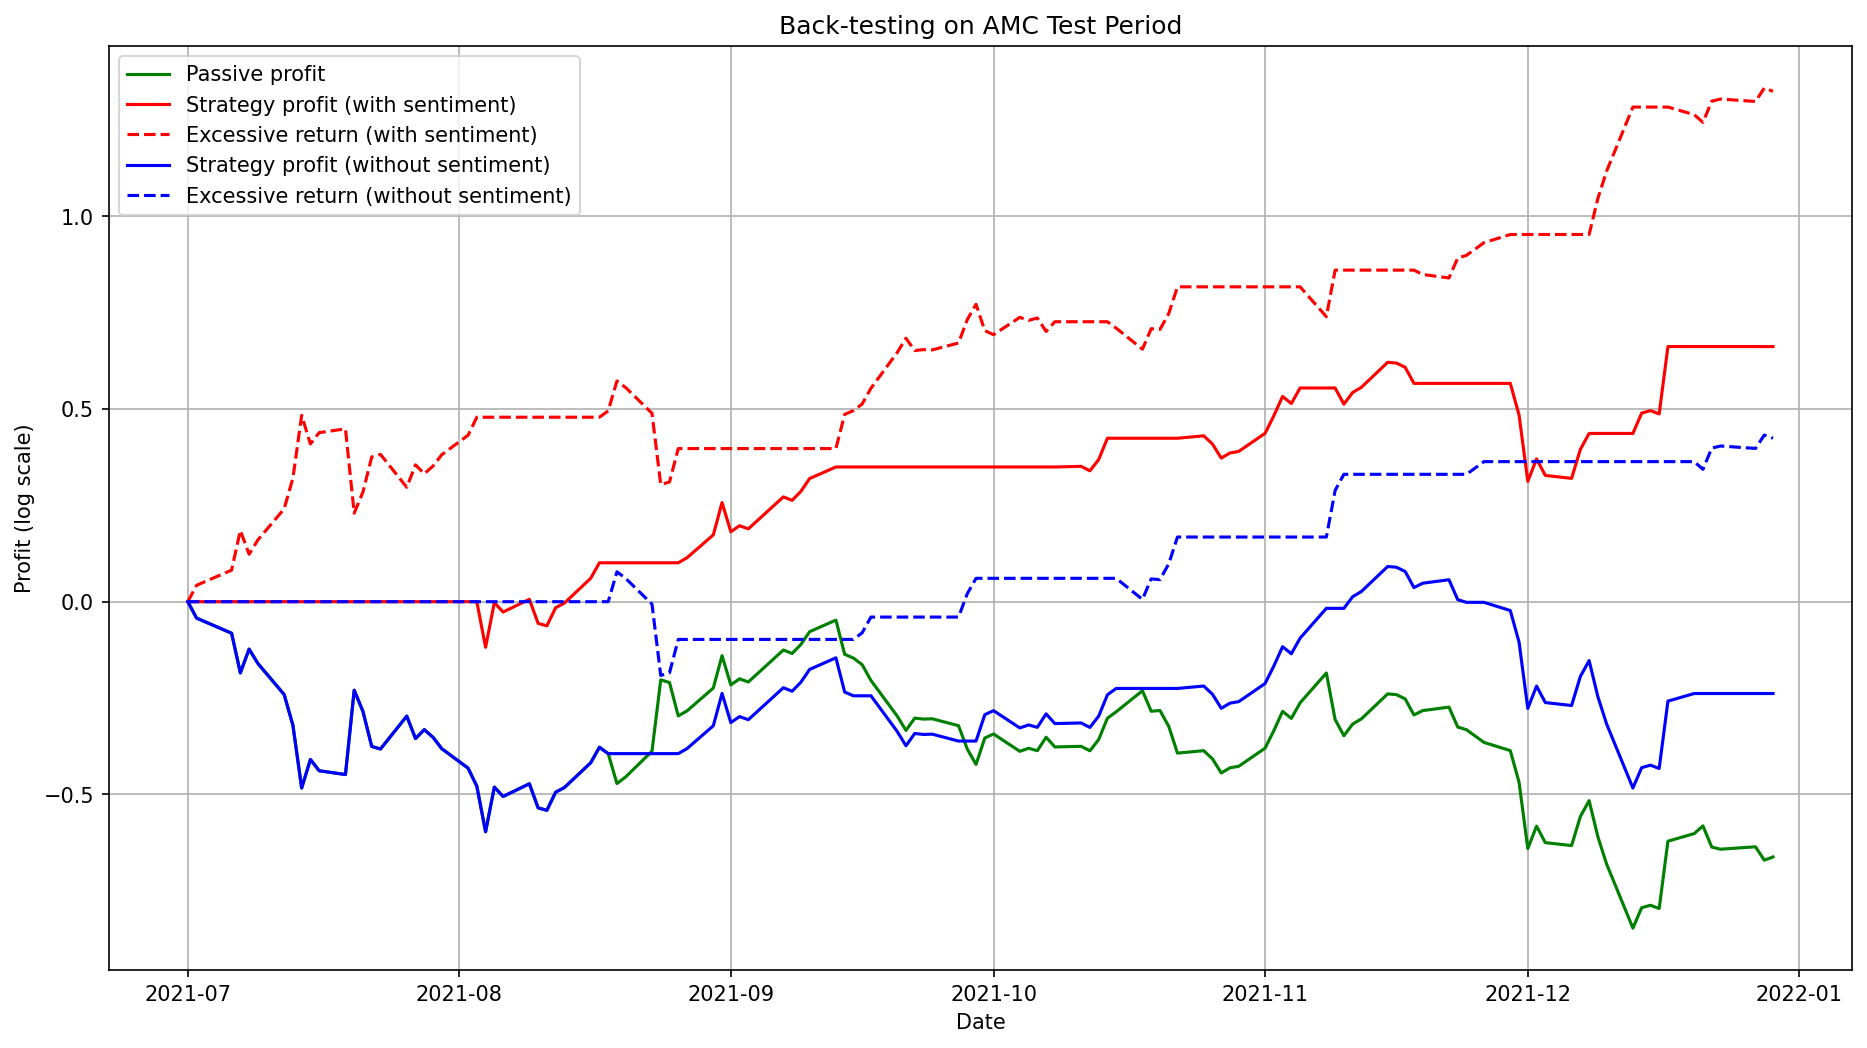

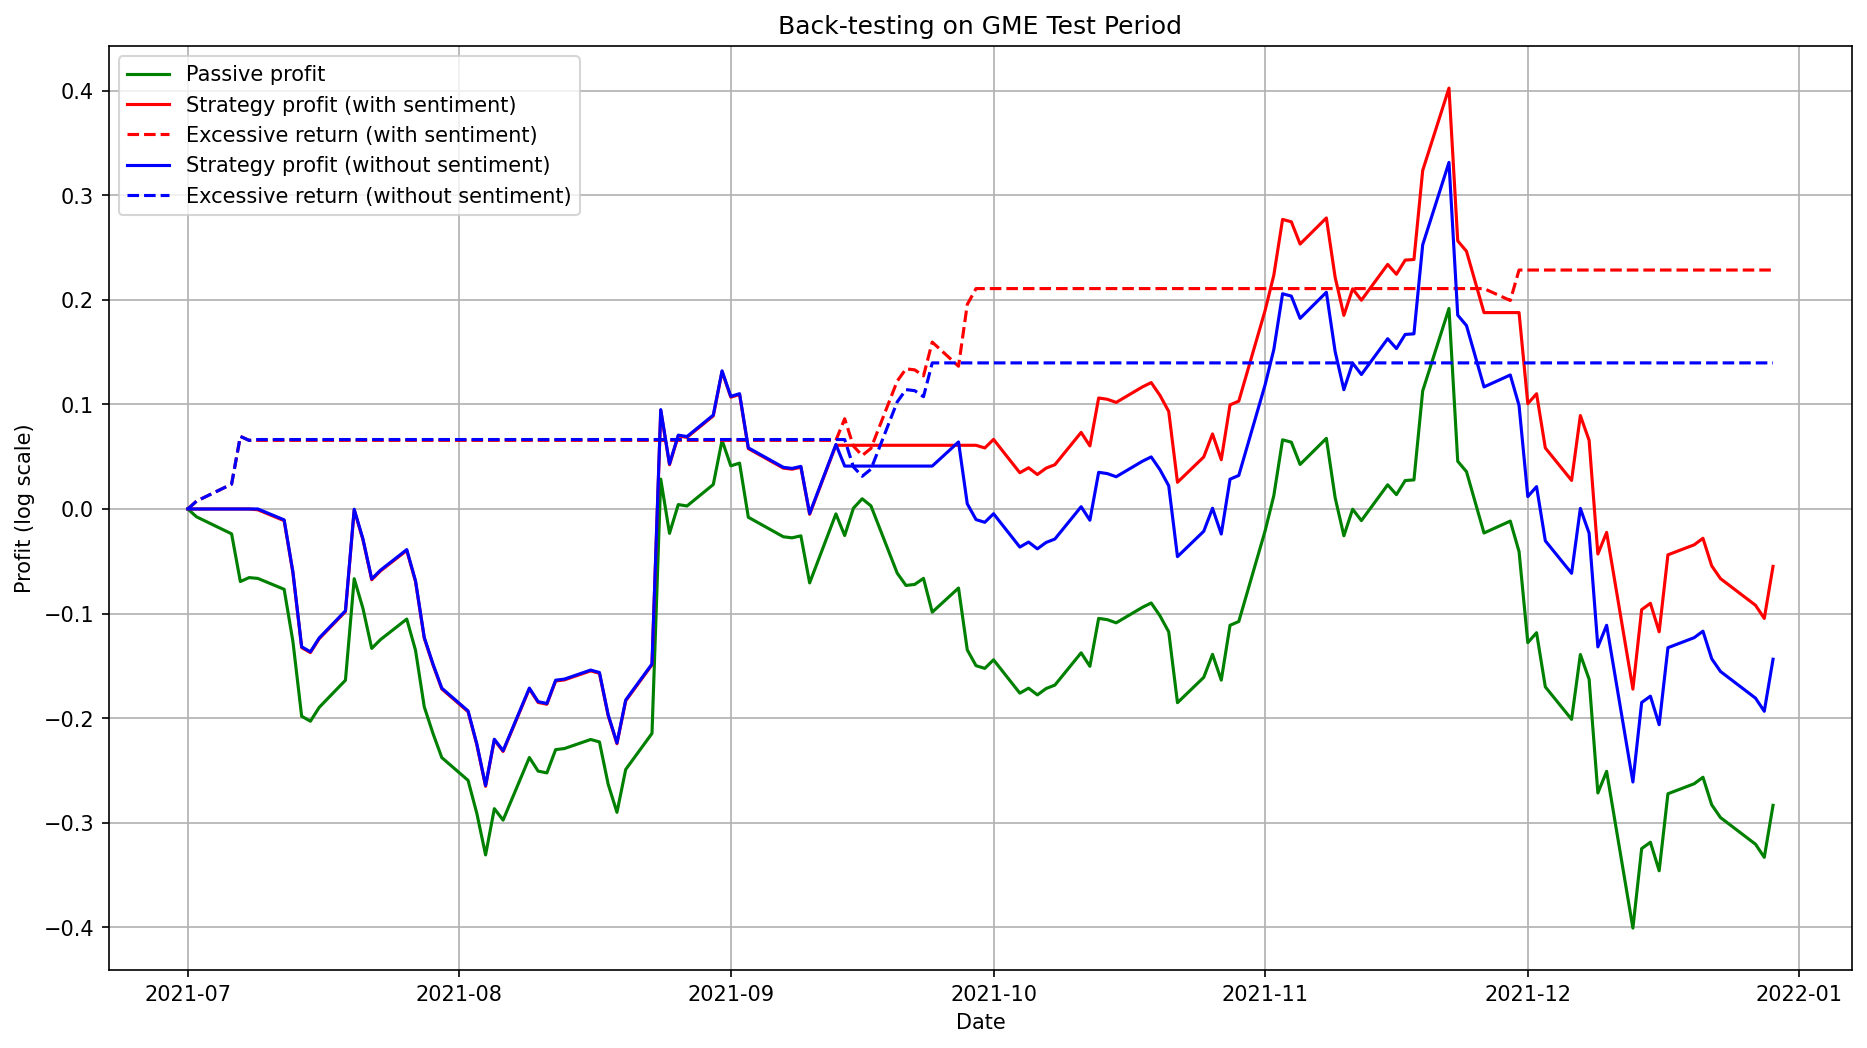

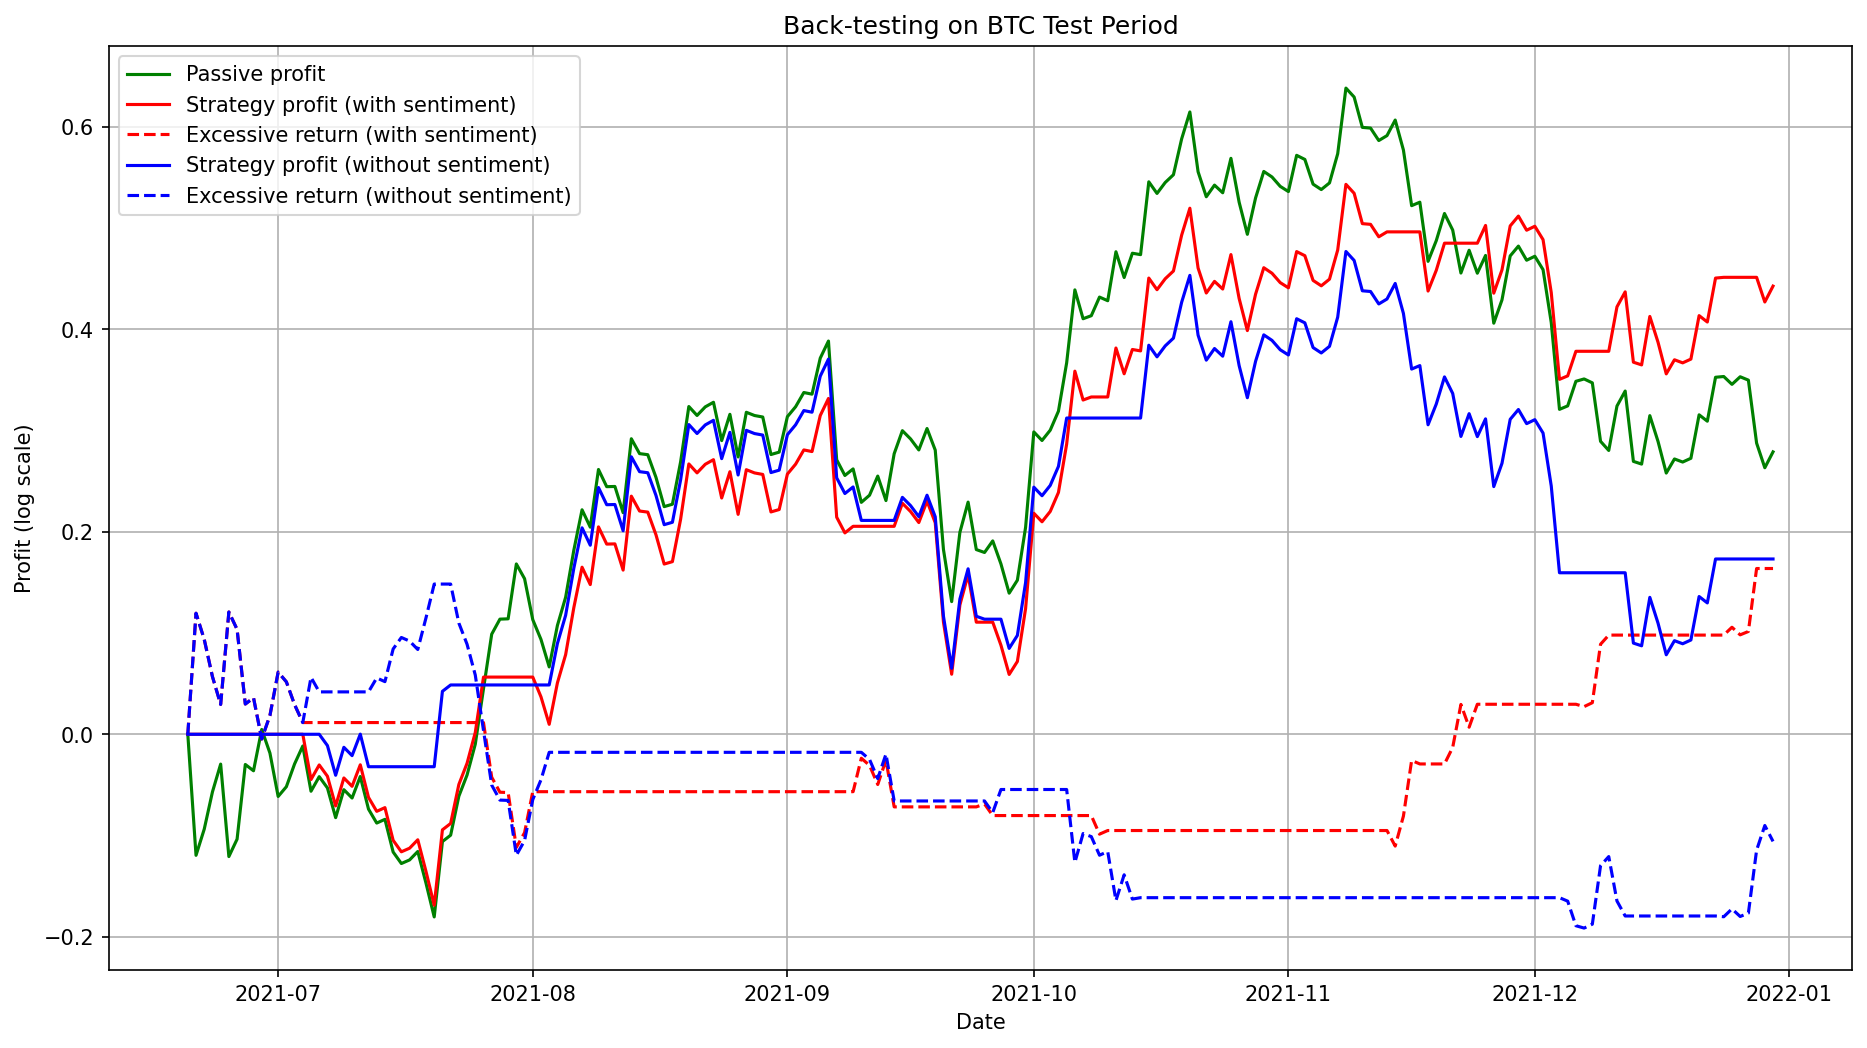

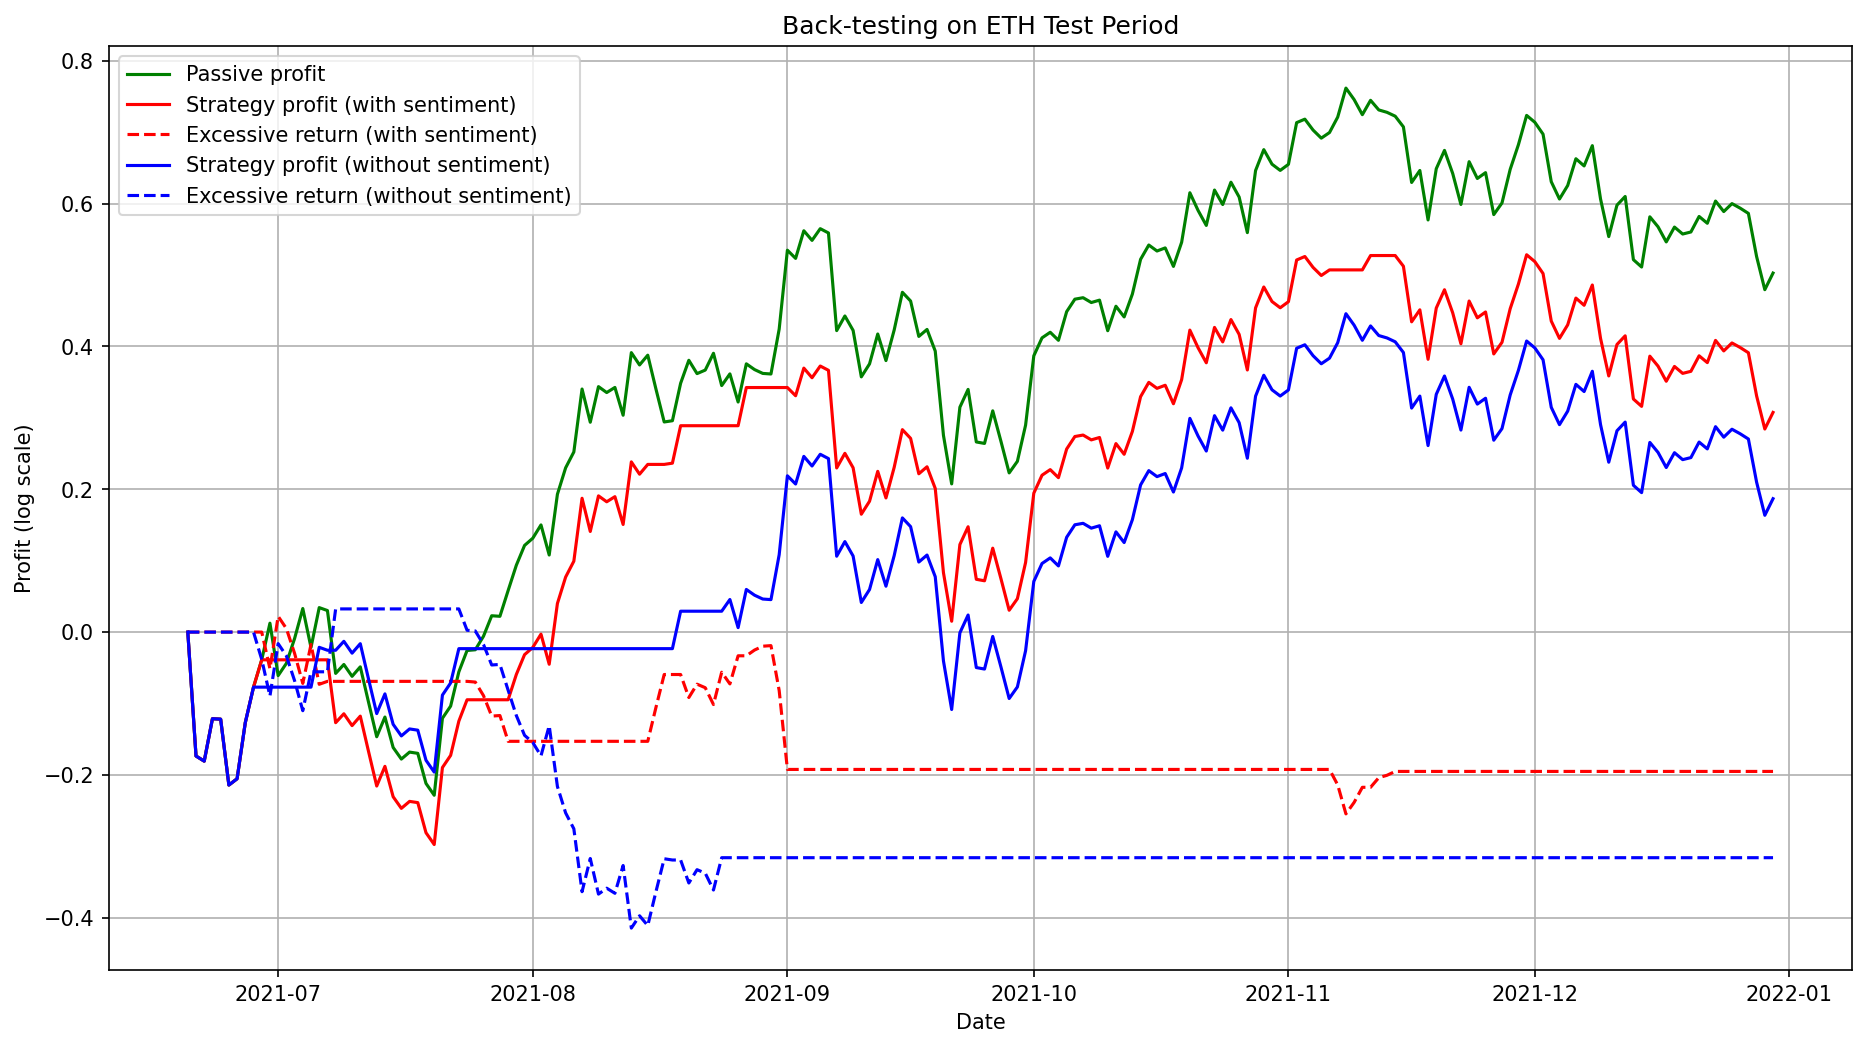

In [ ]:
# Visualize back-testing results
names = ["amc", "gme", "btc", "eth"]
for name in names:
  passive_profit, strategy_profit_ws = back_test(prediction[name]["ws"], stock_datasets[name]["test"]["ws"][2], short_allowed=False)
  _, strategy_profit_ns = back_test(prediction[name]["ns"], stock_datasets[name]["test"]["ns"][2], short_allowed=False)
  drawing(passive_profit, strategy_profit_ws, strategy_profit_ns, name)


### Transformer (attention mechanism)

In [ ]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [ ]:
# Attention model (time-series Transformer)
# Time to vector layer (equivalent to positional encoding)
class Time2Vec(nn.Module):

    def __init__(self, input_size, output_size, f):
        super().__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(input_size, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))

        self.w1 = nn.parameter.Parameter(torch.randn(input_size, output_size-1))
        self.b1 = nn.parameter.Parameter(torch.randn(output_size-1))

        self.f = f # non-linear periodic function

    def forward(self, x):
        """
            x [batch_size, seq_len, input_size], format: tensor float
            output [batch_size, seq_len, output_size]
        """
        non_periodic = torch.matmul(x, self.w0) + self.b0
        periodic = self.f(torch.matmul(x, self.w1) + self.b1)

        output = torch.cat([periodic, non_periodic], dim=-1)

        return output


# Model class
class TransformerModel(nn.Module):
    def __init__(self, t2v_input_size, t2v_output_size, output_size, d_model, nhead, d_hid, nlayers, dropout, batch_first=True, f=torch.sin):
        super().__init__()

        self.time2vec = Time2Vec(t2v_input_size, t2v_output_size, f)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=batch_first)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)

        input_size = t2v_input_size + t2v_output_size
        self.embedding = nn.Linear(input_size, d_model)
        self.linear = nn.Linear(d_model, output_size)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1

        self.embedding.bias.data.zero_()
        self.embedding.weight.data.uniform_(-initrange, initrange)

        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask = None):
        """
            src [batch_size, seq_len, t2v_input_size]
            src_mask [seq_len, seq_len]

            output [batch_size, seq_len, output_size]
        """
        src = torch.concat([src, self.time2vec(src)], dim=-1)
        src = self.embedding(src)
        output = self.transformer_encoder(src, src_mask, is_causal=True)
        output = self.linear(output)
        return output


# Training function
def transformer_training(data, target, t2v_input_size, t2v_output_size, output_size, d_model, nhead, d_hid, nlayers, dropout, lr, momentum, epochs, batch_size):
    model = TransformerModel(t2v_input_size, t2v_output_size, output_size, d_model, nhead, d_hid, nlayers, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    num_batches = int(np.ceil(len(data) / batch_size))
    model.train()
    for epoch in range(epochs):
      err = 0
      tot_loss = 0
      print(f"----------------------Epoch {epoch+1}/{epochs} Starts-----------------------\n")
      batch_num = 0
      while batch_num < num_batches:
        optimizer.zero_grad()
        X_train, y_train = get_batch(data, target, batch_size, batch_num)
        X_train = torch.from_numpy(X_train).float().to(device)
        y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)
        X_train_mask = (1 - torch.triu(torch.ones(X_train.shape[1], X_train.shape[1]), diagonal=1)).bool().to(device)
        # Forward pass
        output = model(X_train, X_train_mask)
        output = output[:,-1,:]
        loss = criterion(output, y_train)
        # Backward pass
        loss.backward()
        optimizer.step()
        batch_num += 1

        pred = torch.argmax(output, dim=1)
        err += ((~(pred == y_train)).sum().item() / len(y_train))
        tot_loss += loss.item()

      err /= num_batches
      tot_loss /= num_batches
      print(f"Batch {epoch+1}/{epochs} Loss: {tot_loss:.4f} Error: {err:.4f}\n")
      print(f"----------------------Epoch {epoch+1}/{epochs} Ends-----------------------\n")
    return model


# Validation function
def transformer_val(model, data, target, batch_size):
    model.eval()
    num_batches = int(np.ceil(len(data) / batch_size))
    batch_num = 0
    correct = 0
    prediction = []
    with torch.no_grad():
      for batch_num in range(num_batches):
        X_test, y_test = get_batch(data, target, batch_size, batch_num)
        X_test = torch.from_numpy(X_test).float().to(device)
        y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device)
        output = model(X_test)
        output = output[:,-1,:]
        pred = torch.argmax(output, dim=1)
        for i in pred.detach().cpu().numpy().tolist():
          prediction.append(i)
        correct += (pred == y_test).sum().item()
        batch_num += 1

    return correct / len(data), prediction


# Function to draw backtest graph
def drawing(passive_profit, strategy_profit_lstm, strategy_profit_att, name):
  # Add one row ahead of Series as the starting day with initial profit 1
  idx = pd.to_datetime(pd.to_datetime(passive_profit.index[0]) - timedelta(days=1)).strftime('%Y-%m-%d')
  start = pd.Series(index = [idx], data = 1)

  passive_profit = pd.concat([start, passive_profit])
  strategy_profit_lstm = pd.concat([start, strategy_profit_lstm])
  strategy_profit_att = pd.concat([start, strategy_profit_att])


  passive_profit.index = pd.to_datetime(passive_profit.index)
  strategy_profit_lstm.index = pd.to_datetime(strategy_profit_lstm.index)
  strategy_profit_att.index = pd.to_datetime(strategy_profit_att.index)


  # Excessive return
  excessive_lstm = strategy_profit_lstm / passive_profit
  excessive_att = strategy_profit_att / passive_profit


  # Log return
  passive_profit = np.log(passive_profit)

  strategy_profit_lstm = np.log(strategy_profit_lstm)
  excessive_lstm = np.log(excessive_lstm)

  strategy_profit_att = np.log(strategy_profit_att)
  excessive_att = np.log(excessive_att)

  # Drawing
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8), dpi=150)
  ax.plot(passive_profit, label="Passive profit", lw=1.5, c="g", ls="solid")

  ax.plot(strategy_profit_lstm, label="Strategy profit (LSTM)", lw=1.5, c="r", ls="solid")
  ax.plot(excessive_lstm, label="Excessive return (LSTM)", lw=1.5, c="r", ls="dashed")

  ax.plot(strategy_profit_att, label="Strategy profit (Attention)", lw=1.5, c="b", ls="solid")
  ax.plot(excessive_att, label="Excessive return (Attention)", lw=1.5, c="b", ls="dashed")

  ax.set_title(f"Back-testing on {name.upper()} Test Period")
  ax.set_xlabel("Date")
  ax.set_ylabel("Profit (log scale)")
  ax.legend()
  ax.grid()
  plt.show()


In [ ]:
# Train on stocks with sentiment scores
names = ["amc", "gme", "btc", "eth"]
transformer_models = {}
transformer_acc = {}
transformer_pred = {}

for name in names:
    X_train = stock_datasets[name]["train"]["ws"][0]
    y_train = stock_datasets[name]["train"]["ws"][1]

    X_test = stock_datasets[name]["test"]["ws"][0]
    y_test = stock_datasets[name]["test"]["ws"][1]

    t2v_input_size = X_train.shape[-1]
    t2v_output_size = 5
    output_size = 3
    d_model = 512
    nhead = 8
    d_hid = 512
    nlayers = 4
    dropout = 0.2
    lr = 0.001
    momentum = 0.9
    epochs = 100
    batch_size = 8

    model = transformer_training(X_train, y_train, t2v_input_size, t2v_output_size, output_size, d_model, nhead, d_hid, nlayers, dropout, lr, momentum, epochs, batch_size)
    acc, pred = transformer_val(model, X_test, y_test, batch_size)

    transformer_models[name] = model
    transformer_acc[name] = acc
    transformer_pred[name] = pred

----------------------Epoch 1/100 Starts-----------------------

Batch 1/100 Loss: 1.5442 Error: 0.4916

----------------------Epoch 1/100 Ends-----------------------

----------------------Epoch 2/100 Starts-----------------------

Batch 2/100 Loss: 1.5291 Error: 0.5240

----------------------Epoch 2/100 Ends-----------------------

----------------------Epoch 3/100 Starts-----------------------

Batch 3/100 Loss: 1.0077 Error: 0.5260

----------------------Epoch 3/100 Ends-----------------------

----------------------Epoch 4/100 Starts-----------------------

Batch 4/100 Loss: 1.3599 Error: 0.5401

----------------------Epoch 4/100 Ends-----------------------

----------------------Epoch 5/100 Starts-----------------------

Batch 5/100 Loss: 0.9910 Error: 0.5010

----------------------Epoch 5/100 Ends-----------------------

----------------------Epoch 6/100 Starts-----------------------

Batch 6/100 Loss: 1.1095 Error: 0.4903

----------------------Epoch 6/100 Ends-----------------

In [ ]:
transformer_acc

{'amc': 0.5238095238095238,
 'gme': 0.5158730158730159,
 'btc': 0.5567010309278351,
 'eth': 0.4639175257731959}

In [ ]:
# Save models and outcomes
torch.save(transformer_models, "/content/drive/MyDrive/ESE 546/Project/Transformer models/models.pt")
torch.save(transformer_pred, "/content/drive/MyDrive/ESE 546/Project/Transformer models/predictions.pt")
torch.save(transformer_acc, "/content/drive/MyDrive/ESE 546/Project/Transformer models/accuracy.pt")

In [ ]:
# Load relevant resutls
lstm_prediction = torch.load("/content/drive/MyDrive/ESE 546/Project/LSTM models/predictions.pt")
transformer_pred= torch.load("/content/drive/MyDrive/ESE 546/Project/Transformer models/predictions.pt")

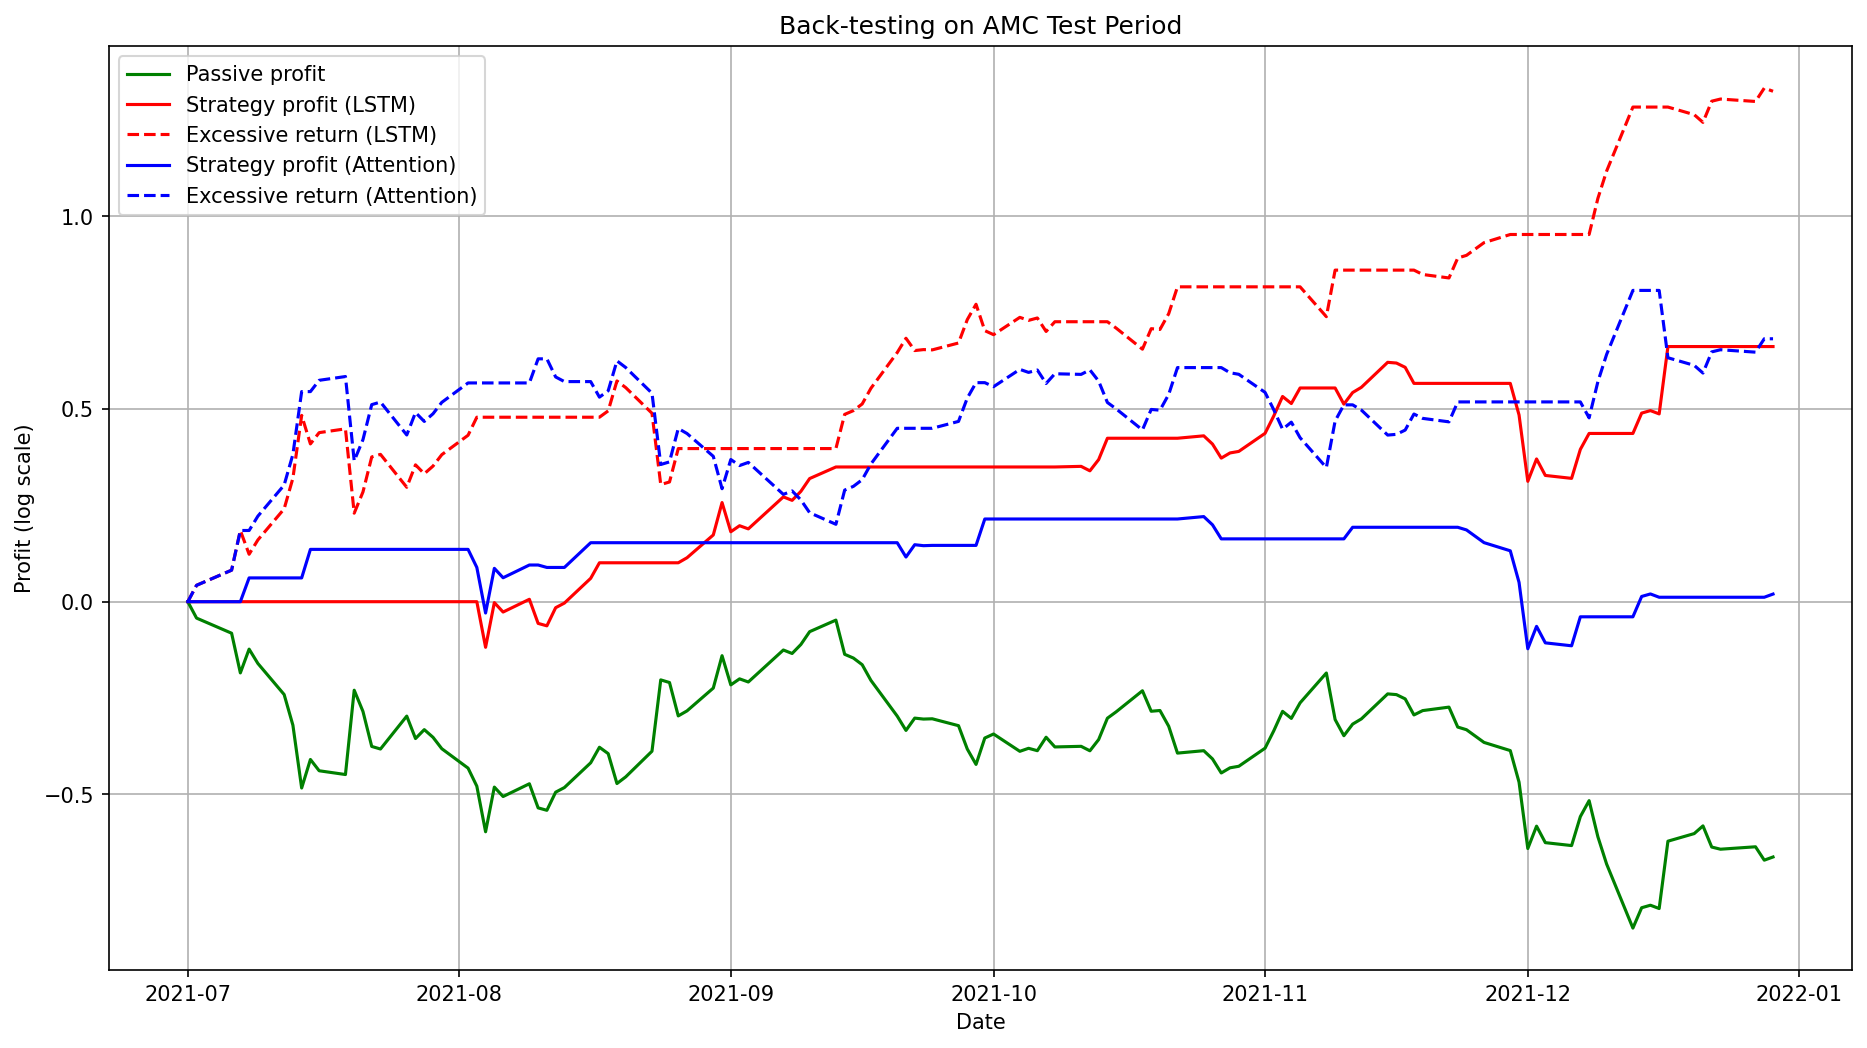

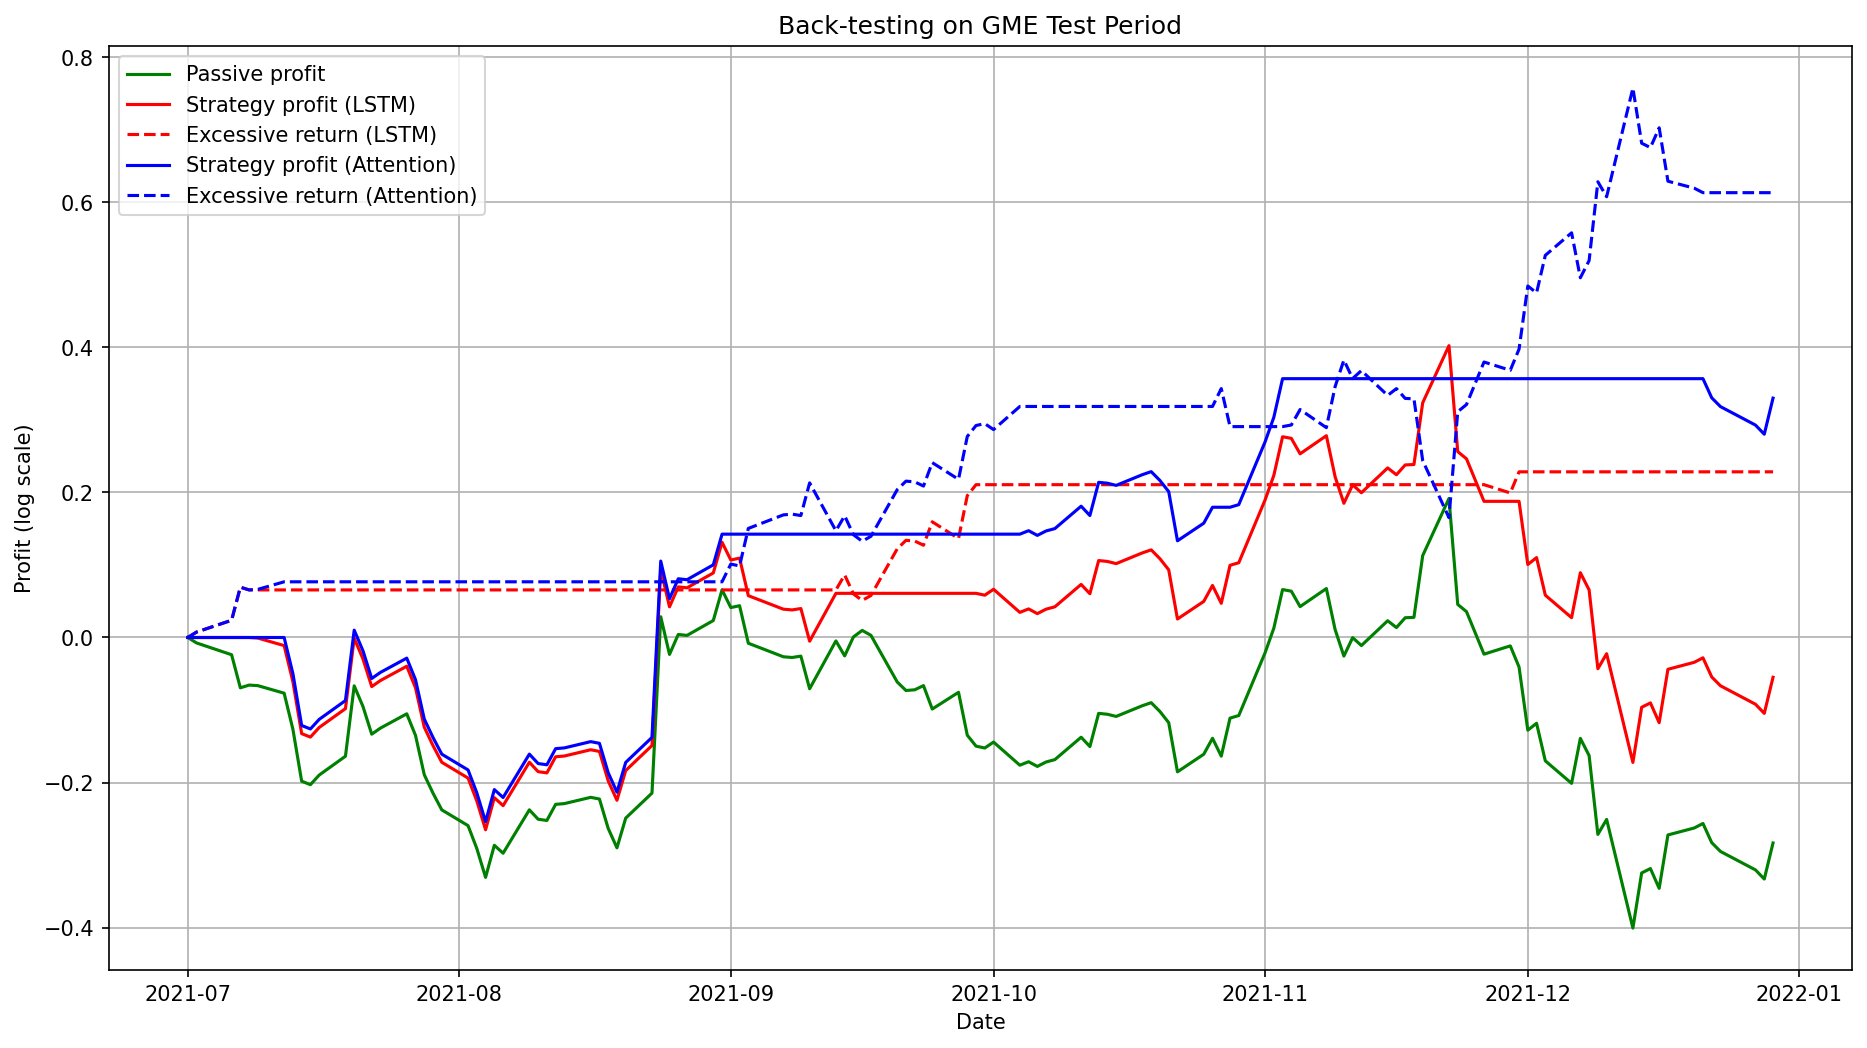

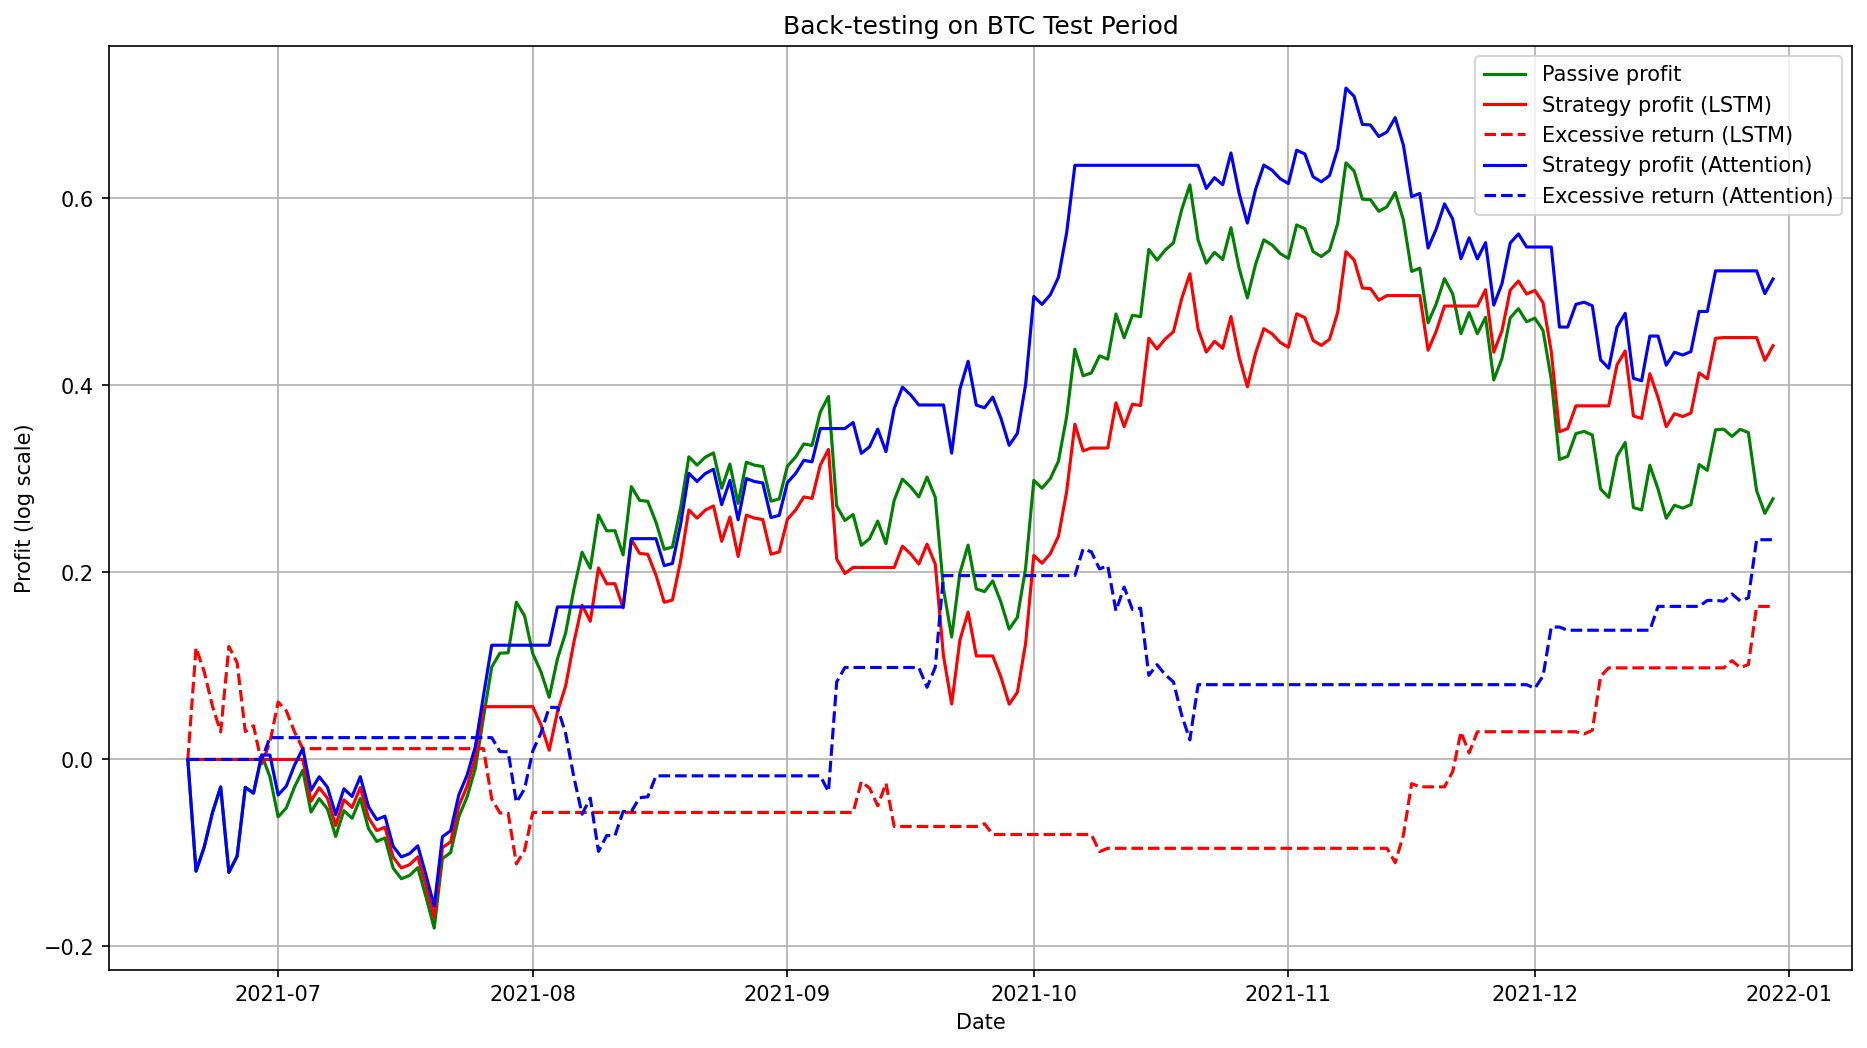

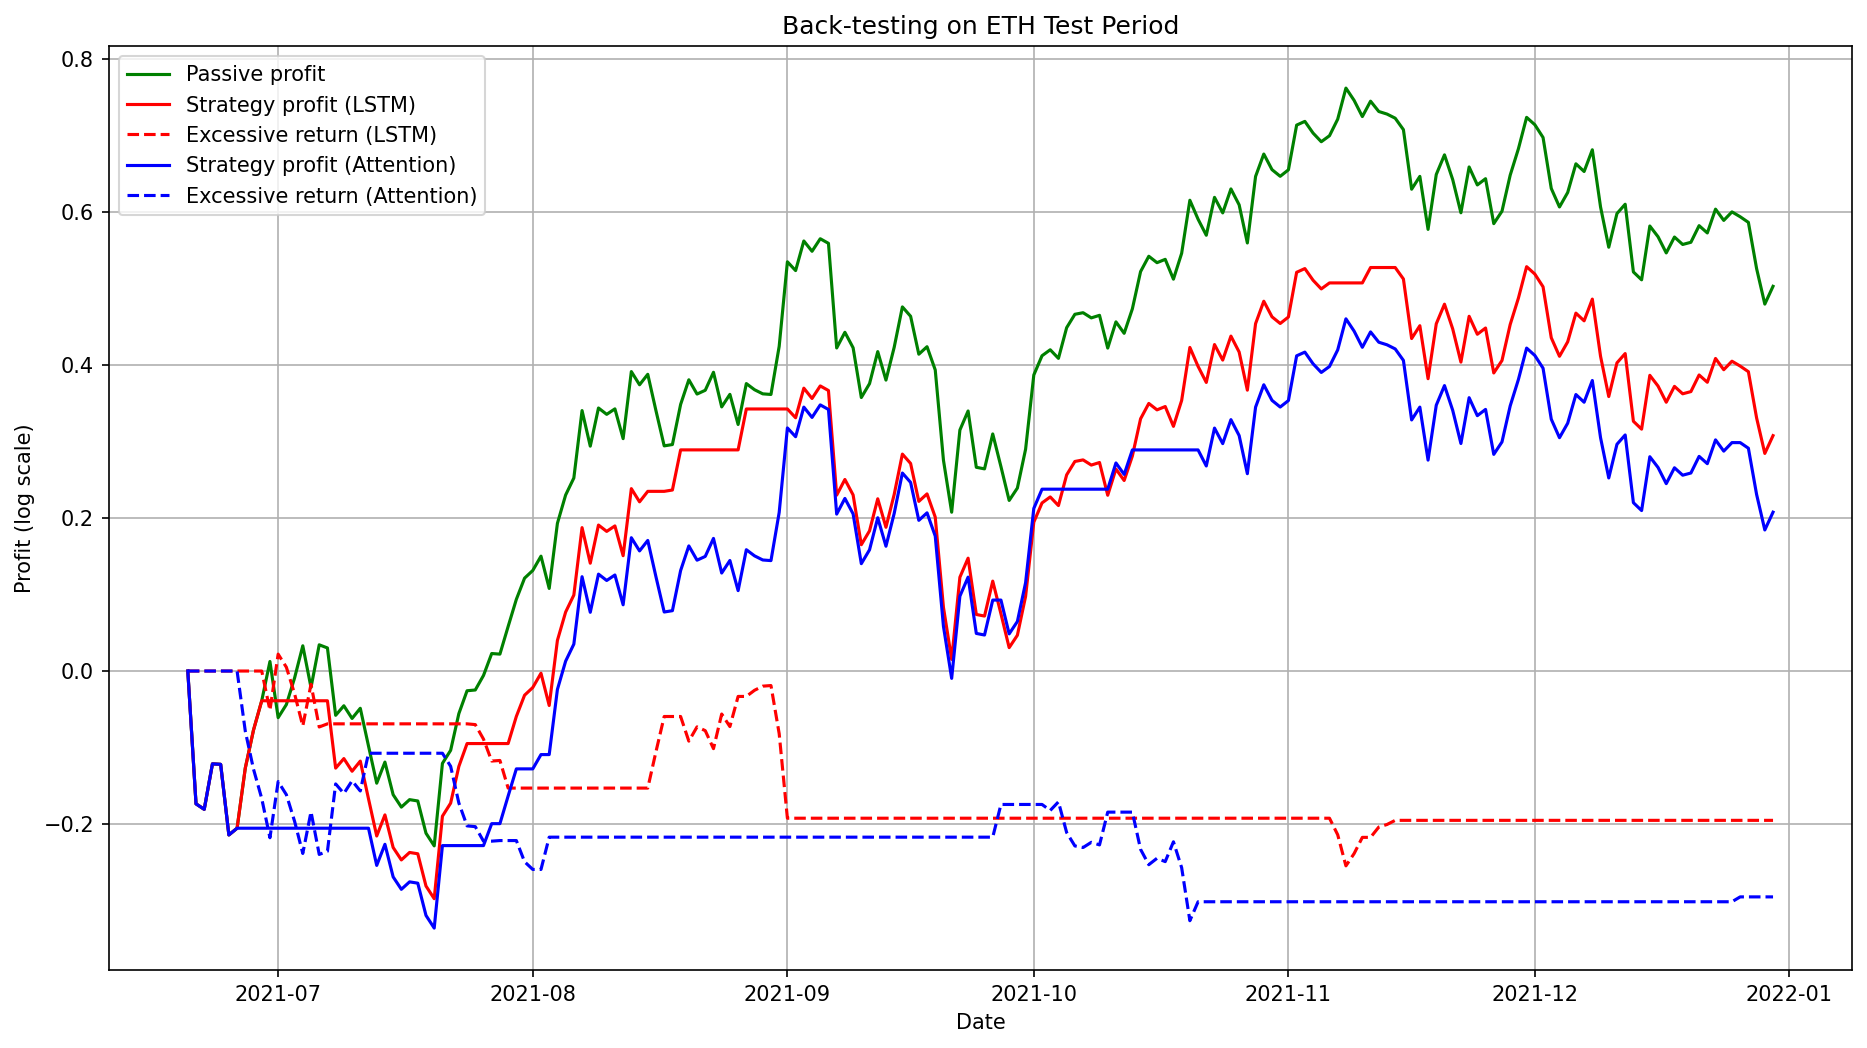

In [ ]:
# Visualize back-testing results
names = ["amc", "gme", "btc", "eth"]
for name in names:
  passive_profit, strategy_profit_lstm = back_test(lstm_prediction[name]["ws"], stock_datasets[name]["test"]["ws"][2], short_allowed=False)
  _, strategy_profit_att = back_test(transformer_pred[name], stock_datasets[name]["test"]["ns"][2], short_allowed=False)
  drawing(passive_profit, strategy_profit_lstm, strategy_profit_att, name)
